**Student:** Luciano Carvalho


# Chapter 6
# Untangling large and complex data

## Introduction

Modern large and complex data sets present significant challenges when one is trying to gain an understanding of the relationships. A few well-chosen summary statistics and charts can show insight for a data set with a small number of samples, few variables and limited categories of categorical variables. However, modern data sets can have tens of millions of samples, thousands, even millions, of variables, and categorical variables with thousands or more of categories.   

Faced with large and complex data set, there is a natural tendency to simply try building models and hope that this process leads to some understanding. However, there is a significant chance that such an approach will be inefficient in terms of time and effort, and may fail to create a meaningful model.     

What practical methods can be applied to these situations? In this chapter we will investigate the answer. Our focus is on methods which are widely applicable. Keep in mind, a combination of creativity and domain-specific methods are often required to develop a complete understanding of large and complex data.

It is often the case that the complexity of these relationships in a data set prove more challenging than the size. Some graphical methods are relatively indifferent to size, as are summary statistics. However, dealing with complexity can be challenging, and require ingenuity.

## Scalable Chart Types

Some chart types are inherently scalable. These methods produce displays which produce useful results regardless of the size of the data set. These methods include:      
- **Bar plots:** Counts and resulting plots, such as bar plots, can be computed and displayed at very large scale.      
- **Histograms:** Data can be binned and the bins plotted at a very large scale to create histograms.      
- **Box plots:** Creating box plots requires finding the quartiles of a variable , which is a scalable process. This is particularly the case for subsets of a large data set.      
- **KDE and violin plots:** Similarly to the box plot, plots involving kernel density estimation are quite scalable.      

## Data for Examples   

To understand some of the methods discussed in this chapter, we will use some examples. The data for some of these examples contains the median price of housing by state and county for the United States for 8 years. These data was complied from the [research data made avaialble by Zillow](https://www.zillow.com/research/data/) and based on public records.   

While data preparation is not the focus of either this chapter or this book we will show some details. This process will give you further insight into how EDA and data preparation interact.

The code to import packages and load the data set from a .csv file is shown below.    

In [2]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import numpy.random as nr
import datetime
from math import log
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import mosaicplot
import calendar

housing = pd.read_csv('/content/housing.csv')
print(housing.dtypes)

Unnamed: 0            int64
fips                  int64
county               object
state                object
time                 object
nSold               float64
medListPriceSqft    float64
medSoldPriceSqft    float64
dtype: object


### Working with datetime

Let's look more carefully at the date-time column in the data frame.

In [3]:
print(housing.loc[:5,'time'])

0    2008-01-31
1    2008-02-29
2    2008-03-31
3    2008-04-30
4    2008-05-31
5    2008-06-30
Name: time, dtype: object


The format of the date column presents a problem. It is a plain string, and cannot be interpreted by Pandas or Seaborn. Therefore some transformation of this variable is required. The following steps are used to change the format:
- The variable is coerced to the Pandas `datetime` type.   
- Since Seaborn will not always use the Pandas `datetime` type correctly, a column with the date in decimal years is created.


In [4]:
## Create a datetime type column and a decimal year column
def date_to_decimal(x,frac=1.0/12.0):
    return x.year + frac * x.month
housing.loc[:,'time'] = pd.to_datetime(housing.loc[:,'time'])
housing.loc[:,'time_decimal'] = housing.loc[:,'time'].map(date_to_decimal)
housing.loc[:5,['time','time_decimal']]

time  time_decimal
0  2008-01-31 00:00:00   2008.083333
1  2008-02-29 00:00:00   2008.166667
2  2008-03-31 00:00:00   2008.250000
3  2008-04-30 00:00:00   2008.333333
4  2008-05-31 00:00:00   2008.416667
5  2008-06-30 00:00:00   2008.500000

### Dealing with missing values

Next, we need to investigate the presence of missing values in the variables. In this case, the missing values are NULLs. The code below loops through the variables in the data frame finds and sums the null values.  

In [5]:
for col in housing.columns:
    missing = housing.loc[:,col].isnull().sum()
    print('For {} the number of missing values = {}'.format(col,missing))

For Unnamed: 0 the number of missing values = 0
For fips the number of missing values = 0
For county the number of missing values = 0
For state the number of missing values = 0
For time the number of missing values = 0
For nSold the number of missing values = 146595
For medListPriceSqft the number of missing values = 20077
For medSoldPriceSqft the number of missing values = 131227
For time_decimal the number of missing values = 0


There are quite a few missing values, particularly for the `medSoldPriceSqft` column. The sale price of the house is of most interest, but nearly half of these values are missing. Many US states do not record the sale price of homes in the public record. The lack of reporting results in the large number of missing values.

These missing values may not be randomly distributed. Since these data are time ordered, we can investigate if there is a patern of missing values in time. Execute the code in the cell below to plot number of missing values within time bins for the variables with missing values.    

<ipython-input-6-07e30999e82c>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_bins = housing.loc[:,missing_cols].groupby('bins').sum()


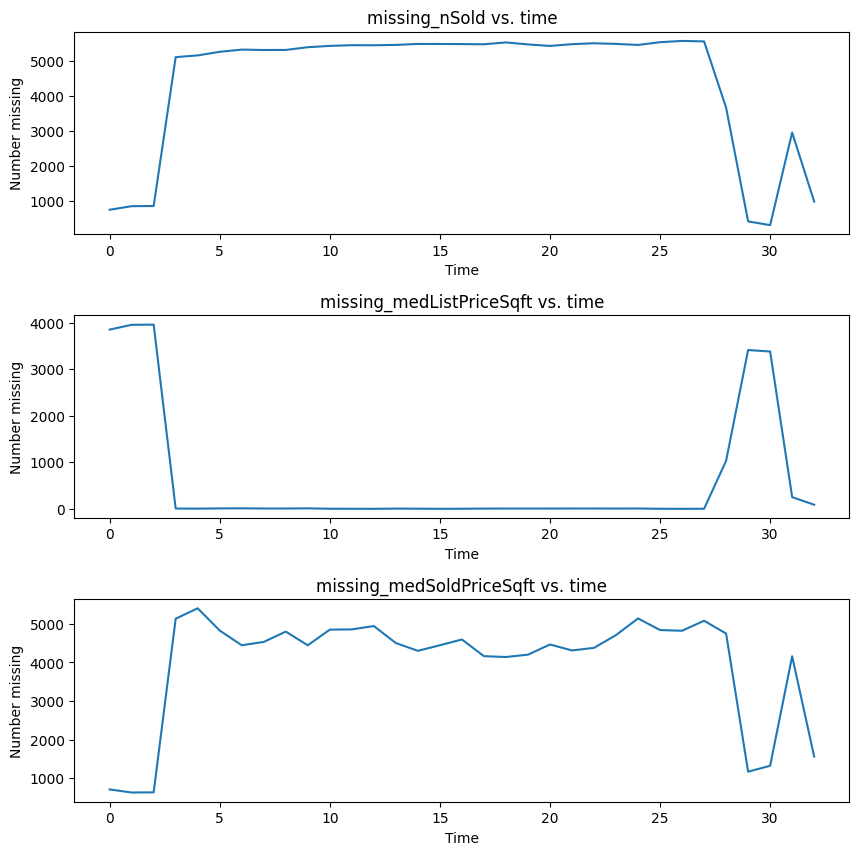

In [6]:
def plot_missing(df, col, ax_i):
    sns.lineplot(data=df, x='bin_number', y=col, ax=ax_i)
    _=ax_i.set_title(col + ' vs. time')
    _=ax_i.set_xlabel('Time')
    _=ax_i.set_ylabel('Number missing')

## Create time bins for the data
bins = [2008.0 + i * 0.25 for i in range(34)]
housing.loc[:,'bins'] = pd.cut(housing.loc[:,'time_decimal'], bins=bins)# .sum() #.reset_index()

## Create indicator variable for columns with missing values
cols = ['nSold','medListPriceSqft','medSoldPriceSqft']
for col in cols:
    housing.loc[:,'missing_'+col]=housing.loc[:,col].isnull()

## Groupby bins and sum missing counts
missing_cols = ['bins'] + ['missing_'+col for col in cols]
missing_bins = housing.loc[:,missing_cols].groupby('bins').sum()
missing_bins['bin_number'] = [i for i in range(len(missing_bins))]

## plot time sequence of missing values
fig, ax = plt.subplots(3,1, figsize=(10,10))
fig.subplots_adjust(hspace=0.4)
for ax_i, col in zip(ax, missing_cols[1:]):
    plot_missing(missing_bins, col, ax_i)

We are primarily interested in the median sold pirce per square foot. A possible treatment for these missing values is to substitute the median list price as an approximation for the median sold price. The code below makes this substitution and tests the result.

Number of missing values after using proxies = 5415


<ipython-input-7-2a783fd34b31>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_bins = housing.loc[:,missing_cols].groupby('bins').sum()


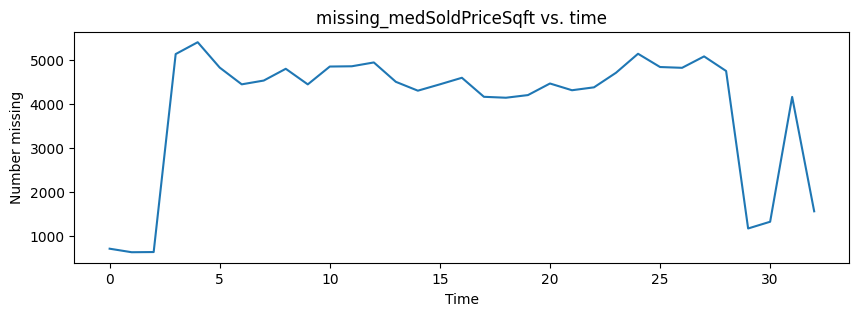

In [7]:
## Fill the missing median sold price with listing price
housing.loc[housing.loc[:,'medSoldPriceSqft'].isnull(),'medSoldPriceSqft'] = housing.loc[:,'medListPriceSqft']
## Test the result
print('Number of missing values after using proxies = ' +str(housing.loc[:,'medSoldPriceSqft'].isnull().sum()))

## Groupby bins and sum missing counts
missing_cols = ['bins'] + ['missing_medSoldPriceSqft']
missing_bins = housing.loc[:,missing_cols].groupby('bins').sum()
missing_bins['bin_number'] = [i for i in range(len(missing_bins))]

fig, ax = plt.subplots(figsize=(10,3))
plot_missing(missing_bins, 'missing_medSoldPriceSqft', ax)

There are still some missing values, but many fewer. Unfortunately, these missing values are concentrated in time, which will bias any analysis. Given the small number, we will just delete the cases with the missing values. This is done in the code below.  

> **Note on treating missing values:** In this example we have addressed the missing values by using proxy values, the listing price. For the remaining missing values we could take other actions besides removing the cases, forward or backward fill or interpolate. These alternatives can be used since the values are time ordered.


In [8]:
## Remove the remaining rows with missing median sold price values
medSoldNotMissing = housing.loc[:,'medSoldPriceSqft'].notnull()
housing = housing.loc[medSoldNotMissing,:]
housing.shape

(241667, 13)

### Treatment of outliers

Now that the missing values have been dealt with, Let's have a first look at these data. The code below creates two basic exploratory plots, a scatter plot and a distribution plot.       

> **Scalability note 1:** The housing data set contains a great many cases. This makes rendering scatter plots difficult in some environments. If the full dataset was displayed, the result with be significant over-plotting or the dreaded 'blob effect'. One solution to this problem is to decimate the data by random sampling. In this case, we will use a Bernoulli sampling scheme to reduce the number of samples to 20% of the original.          

> **Scalability note 2:** While we must decimate the dataset to create usable scatter plot, the distribution plot scales well. Given sufficient computing capacity meaningful distribution plots can be created for any size dataset.

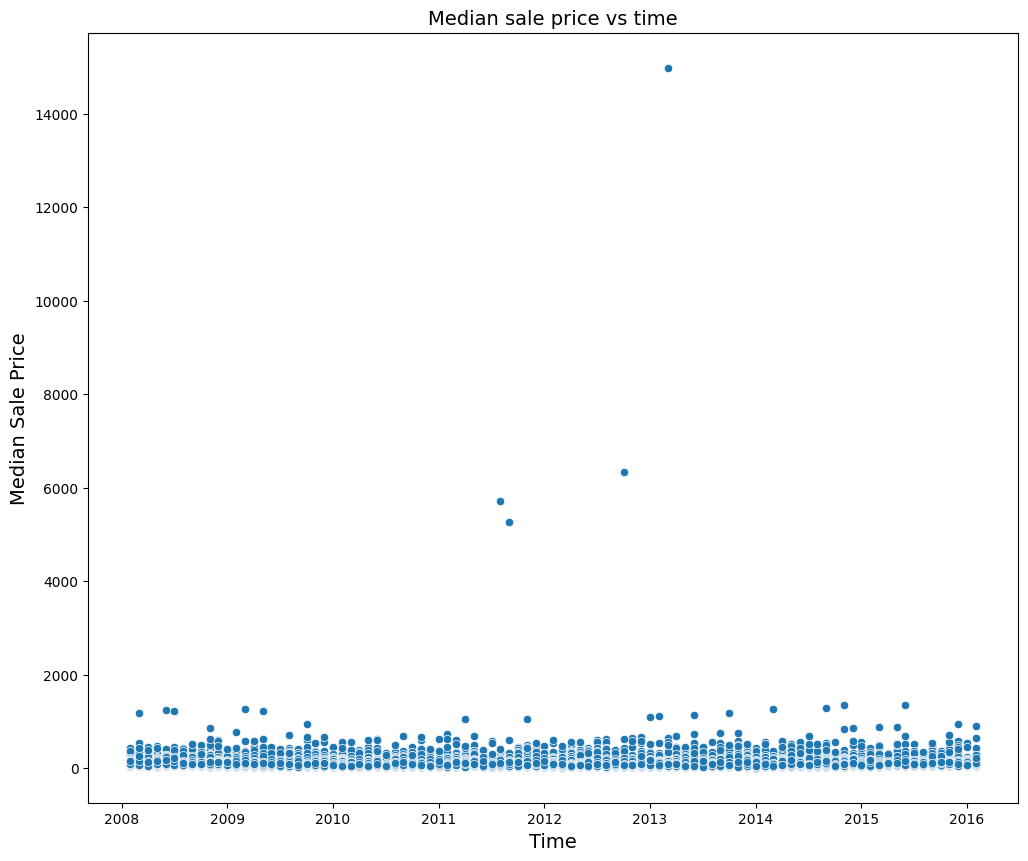

In [9]:
housing_reduced = housing.sample(frac=0.2, axis=0)
fig,ax = plt.subplots(figsize=(12,10))
ax = sns.scatterplot(x='time_decimal', y='medSoldPriceSqft', data=housing_reduced, ax=ax)
_=ax.set_xlabel('Time', fontsize=14)
_=ax.set_ylabel('Median Sale Price', fontsize=14)
_=ax.set_title('Median sale price vs time', fontsize=14)

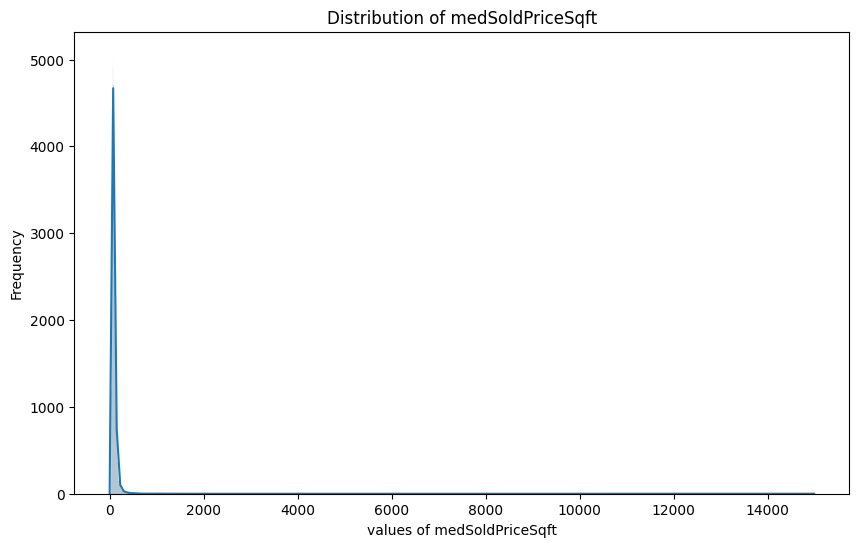

In [10]:
def dist_med_price(df, col):
    fig,ax = plt.subplots(figsize=(10,6))
    ax = sns.histplot(x=df.loc[:,col], kde=True, ax=ax, alpha=0.2)
    _=ax.set_xlabel('values of ' + col) #, fontsize=14)
    _=ax.set_ylabel('Frequency') #, fontsize=14)
    _=ax.set_title('Distribution of ' + col) #, fontsize=14)
    plt.show()
dist_med_price(housing, 'medSoldPriceSqft')

It is clear there are quite a few outliers in the median prices. Some of the values seem impossibly high and impossibly low.    

> **Treating outliers:** Data issues, such as outliers, are best discovered during the EDA process. Once detected, the question is how should outliers be treated. The answer is almost always case-specific. Generally domain knowledge is applied to determine the nature of the outliers: are they errors, indication of a latent variable, or the most interesting values?     

> In this case, we can rely on the fact that the median prices per square foot represent the value of a physical asset. It is the case that some counties will have significantly higher property value than others. But, there are still limits to the range of reasonable values. A more sophisticated treatment could take into account of values in each specific county. Further, it might be possible to attempt to treat the outliers by testing transformations by powers of 10; that is moving decimal points to see if there is a data entry error.     

The code in the cell below filters the Pandas data frame to remove cases with extremely low and extremely high median prices per square foot. The distribution plot of the result is then displayed.  


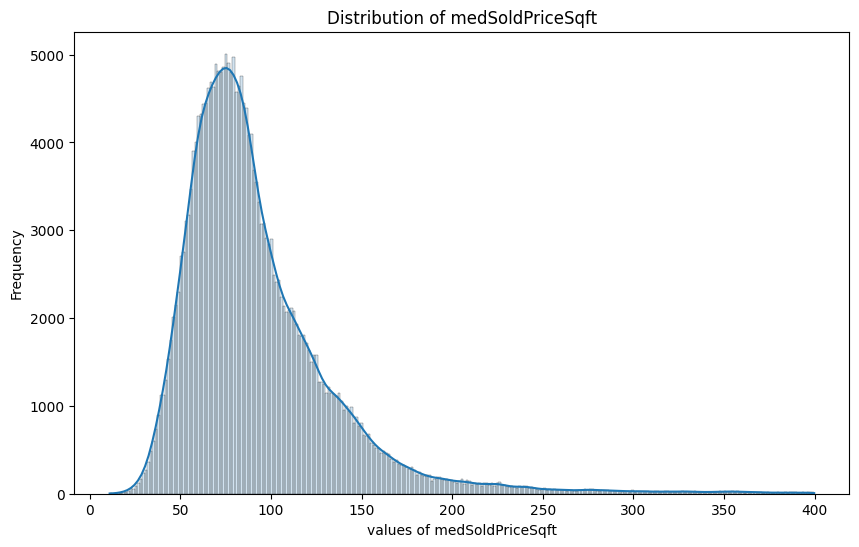

In [11]:
## Filter median price sold
housing = housing.loc[(housing.loc[:,'medSoldPriceSqft'] < 400.0) & (housing.loc[:,'medSoldPriceSqft'] > 10.0),:]
dist_med_price(housing, 'medSoldPriceSqft')

### Transforming distribution

The distribution now shows some significant **right skew** (**positive skew**). This is typical of prices, which are most often greater than zero, and with only a few higher prices. A common approach to make the distribution more symmetric is to apply a logarithmic transformation. The code in the cell below does just this, and displays the distribution plot.   

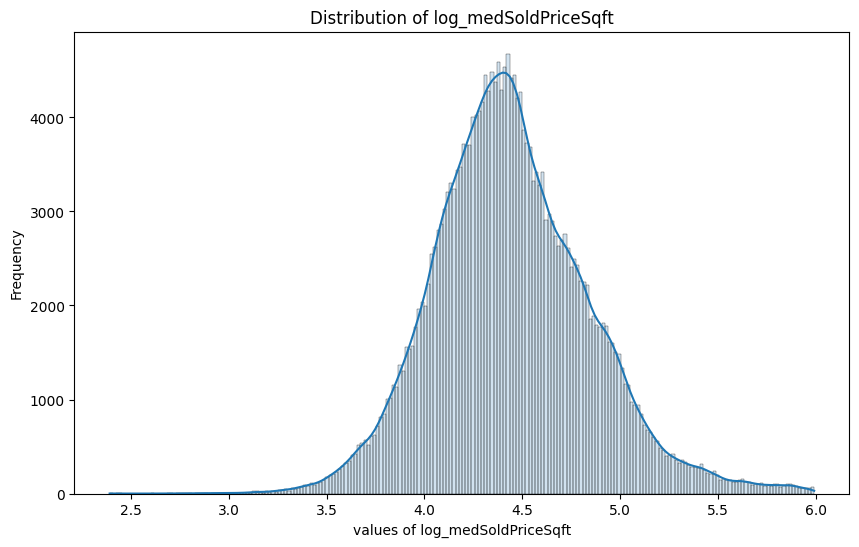

In [12]:
## log transform price and see how this changes the plot
housing.loc[:,'log_medSoldPriceSqft'] = np.log(housing.loc[:,'medSoldPriceSqft'])
dist_med_price(housing, 'log_medSoldPriceSqft')

The distribution of the log median prices per square foot is now close to symmetric. There is still some skew, and a bit of tail on the right. For our purposes this result is adequate.  

## Over-plotting   

**Over-plotting** occurs in scatter plots when the markers lie one on another. This situation is common, even in relatively small data sets. With even moderate size data set scatter plots can look like a blob and be completely uninterpretable. Since scatter plots are widely used, over-plotting is a significant problem in exploratory data analysis and presentation graphics.       

To illustrate the over-plotting problem and demonstrate possible solutions, we will use a US housing data set. This data set is large enough that over plotting in scatter plots is a significant problem.   

In this section we will explore several methods commonly used to deal with over-plotting. Several of these methods can be used concurrently to improve perception of relationships in scatter plots. These methods include:

- **Marker transparency:** Making markers partially transparent, so one can see markers underneath. Transparency is useful in cases with minimal overlap of markers and in conjunction with other methods. If markers are too transparent the viewer cannot see them.     
- **Marker size:** Reducing marker size can reduce over-plotting for obvious reasons. Reduced marker size can be used in combination with marker transparency. There are limits, as the markers must still be easily visible.     
- **Adding jitter:**  It is common for a scatter plot to have one variable or  to have a finite number of values. For example, a variable might have integer values or be coarsely quantized. This situation often leads to significant over-plotting. Adding a bit of random **jitter** to one or both variables can improve this situation in some cases. We will work though an example applying jitter in another section of this chapter.     
- **Hex bin plots:** The above methods can only go so far. For truly large data sets a different approach is required. The hex bin plot is the 2-dimensional equivalent of the histogram. The frequency of values is tabulated into 2-dimensional hexagonal bins which are then displayed using a sequential color palette.    
- **2-d kernel density estimation plots:** Another approach for moderately large data is a 2-dimensional KDE plot. This method is a natural extension of the 1-dimensional KDE plot we applied in Chapter 3.   
- **Creative alternatives:** In some cases, there are alternatives to a scatter plots, which might show relationships effectively. These alternatives are often situation specific, and finding a good one can require significant creativity!  

### Base case  

As a baseline case to refer to, we will create a scatter plot applying no particular method to deal with over-plotting. The code below plots median home price vs. time for all locations in the US.  

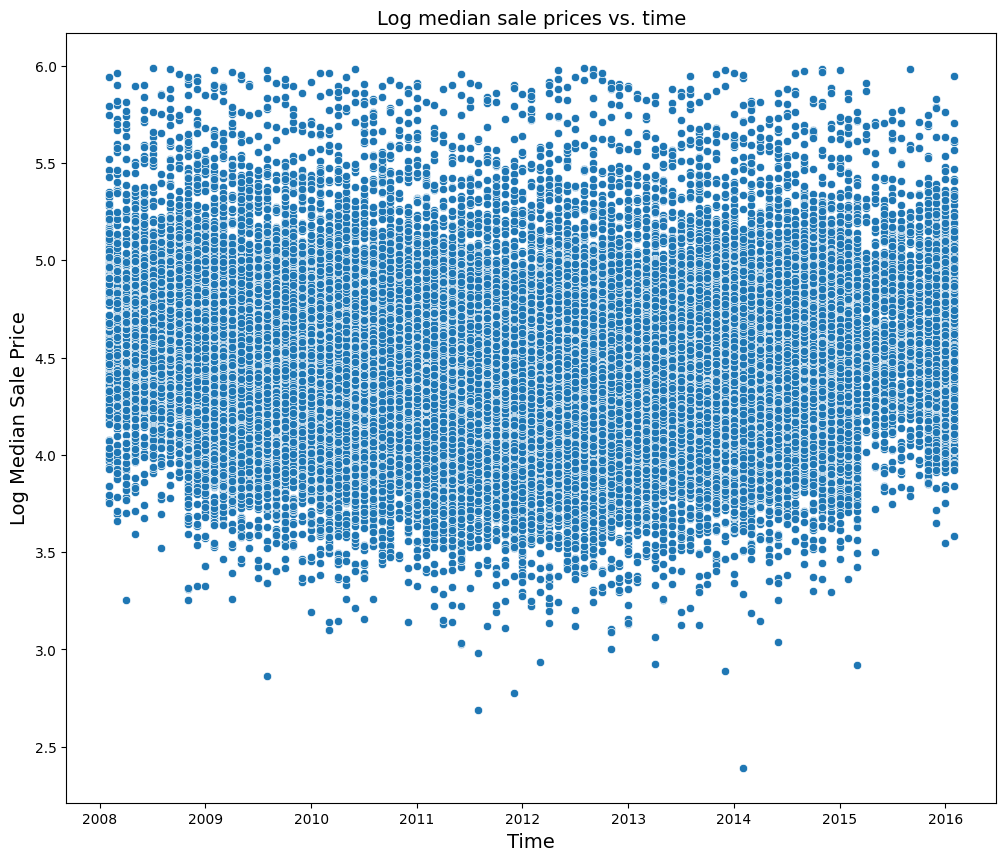

In [13]:
housing_reduced = housing.sample(frac=0.2, axis=0)

fig,ax = plt.subplots(figsize=(12,10))
ax = sns.scatterplot(x='time_decimal', y='log_medSoldPriceSqft', data=housing_reduced, ax=ax)
_=ax.set_xlabel('Time', fontsize=14)
_=ax.set_ylabel('Log Median Sale Price', fontsize=14)
_=ax.set_title('Log median sale prices vs. time', fontsize=14)
plt.show()


This plot is impossible to interpret. The over-plotting has obfuscated all detail.

### Marker transparency

Marker transparency allows the viewer to see though some markers to see other markers underneath. In many scientific graphics systems, an opacity argument, generally designated $\alpha$, is used. In this case, transparency is $1-\alpha$. The smaller the value of $\alpha$, the more transparent the markers.   

The code in the cell below creates a scatter plot of the housing data using a transparency of $0.9$, or $1 - 0.1$.

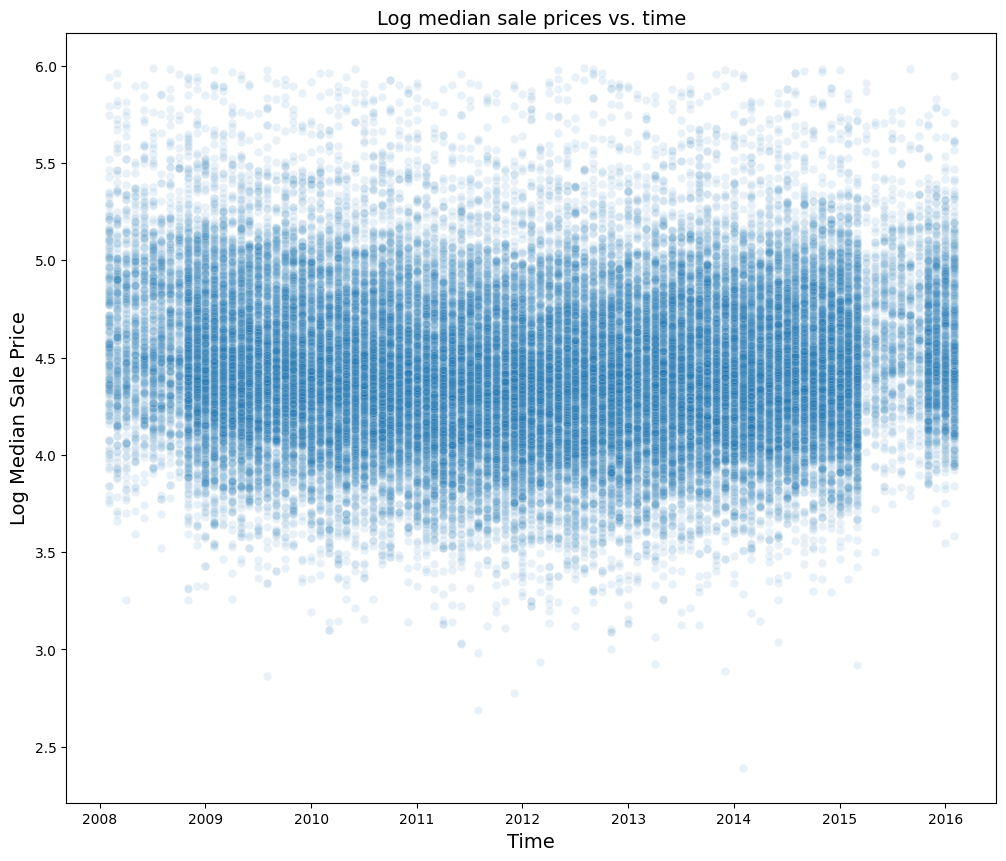

In [14]:
fig,ax = plt.subplots(figsize=(12,10))
ax = sns.scatterplot(x='time_decimal', y='log_medSoldPriceSqft', data=housing_reduced, alpha=0.1, ax=ax)
_=ax.set_xlabel('Time', fontsize=14)
_=ax.set_ylabel('Log Median Sale Price', fontsize=14)
_=ax.set_title('Log median sale prices vs. time', fontsize=14)
plt.show()


The plot is quite different from the original. However, it is still impossible to see any detail for the bulk of the data. However, the presence of outliers is now more perceptible.  

> **Treating outliers:** One aspect of this data is now apparent from the plot. There are a number of low value outliers. Recalling that median price is on a log scale, it is likely that these low values represent some type of error. Perhaps, a misplaced decimal point. At the same time, the highest values are truncated. In some cases, it would be advisable to change the value limits on the filters already applied. For now, we will proceed.  

### Marker size

Along with transparency, **reducing marker size** is an effective approach to reduce over-plotting in small and medium sized data sets. The idea is simple. The smaller the marker the less likely it is to overlap with other markers.  

The code below uses both high marker transparency and small marker size to improve the viewer's ability to perceive the relationships in the plot. The `s` or `size` argument is used to set the marker size. Finding a satisfactory marker size can take some experimentation for each particular situation.  

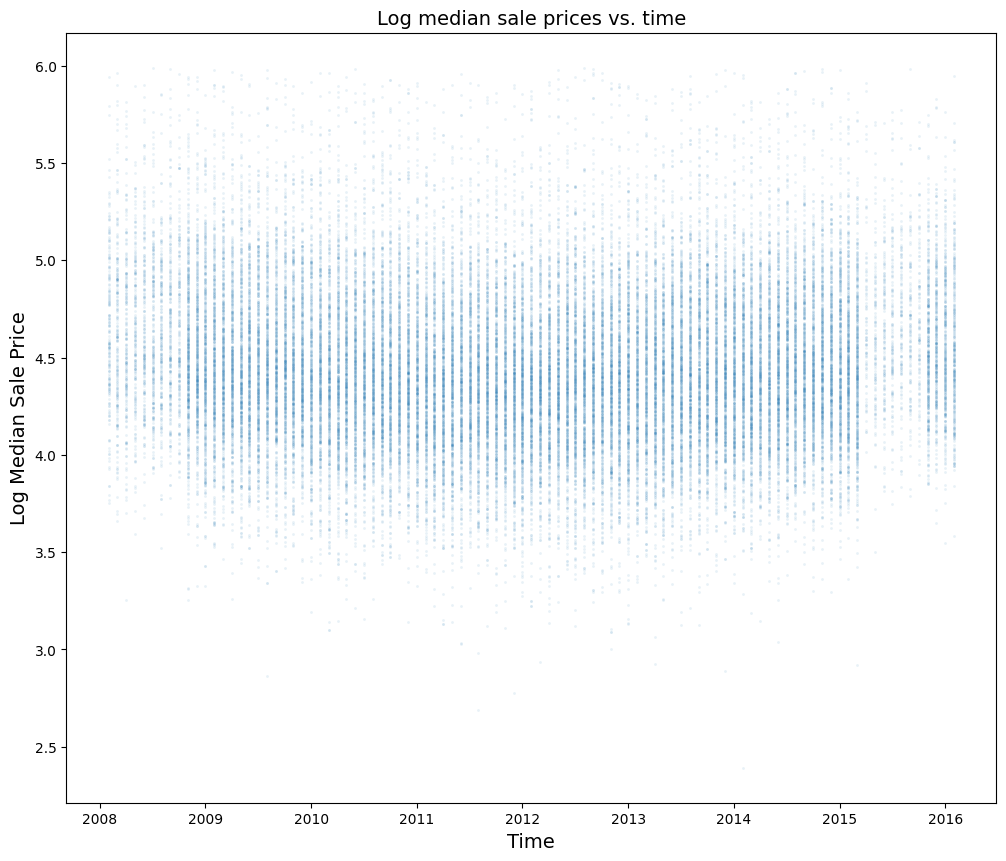

In [15]:
fig,ax = plt.subplots(figsize=(12,10))
ax = sns.scatterplot(x='time_decimal', y='log_medSoldPriceSqft', data=housing_reduced, alpha=0.1,  s=4, ax=ax)
_=ax.set_xlabel('Time', fontsize=14)
_=ax.set_ylabel('Log Median Sale Price', fontsize=14)
_=ax.set_title('Log median sale prices vs. time', fontsize=14)
plt.show()


There is still significant over-plotting, but some structure of the data is starting to emerge. There is a band of median home prices in the mid-range that is now becoming apparent.   

> **Limitations of transparency and marker size:** The limitations of marker size and transparency are apparent in the foregoing example. Increasing transparency and reducing marker size has improved the viewer's ability to perceive the relationships in the plot. However, it is still difficult to view much detail. Further, the markers away from the bulk of the data are becoming hard to see.   

> Transparency and marker size changes are effective only within limits for alleviating over-plotting. Areas with denser markers become easier to see, as fewer marker are obscured. However, as markers become more transparent and smaller, they become harder to see. This trade-off is why these methods are not considered useful for large data sets.

> **Exercise 6-1:** The scatter plots of the auto price data used for examples in Chapter 5 show some over-plotting. For example, over plotting can be seen for gas cars in the 18 to 32 MPG range on the plots of vehicle weight vs. city MPG. First reproduce the plot shown in the **Qualitative Color Palettes** subsection of Chapter 5, with fuel type shown by hue. Then, create a new plot using a combination of marker transparency and size to limit the effect of over plotting. Make a 2x2 plot array wit combinations for `alpha` $= [0.5, 0.2]$ and `size` $=[20,10]$. Make sure to include correct axis labels and titles on each plot. You will likely need to use the 'fontsize' argument for axis lables and titles so the plot is readable.    

(195, 27)


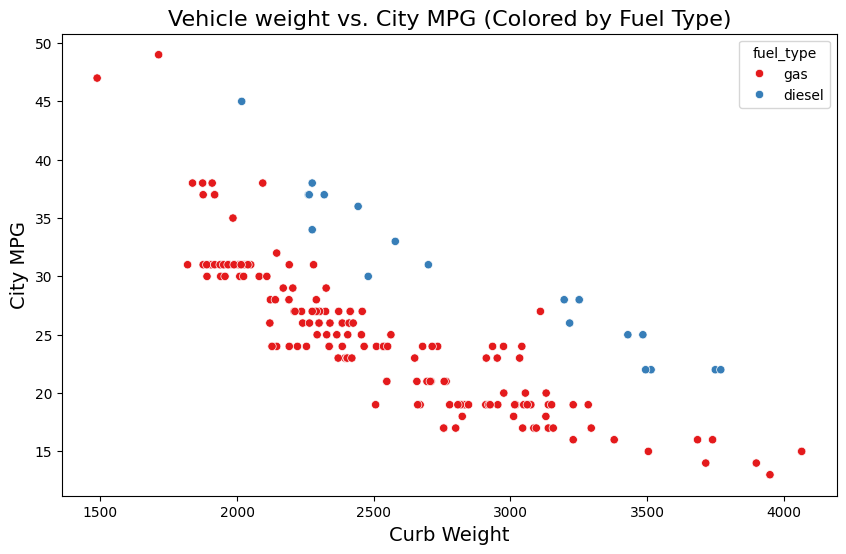

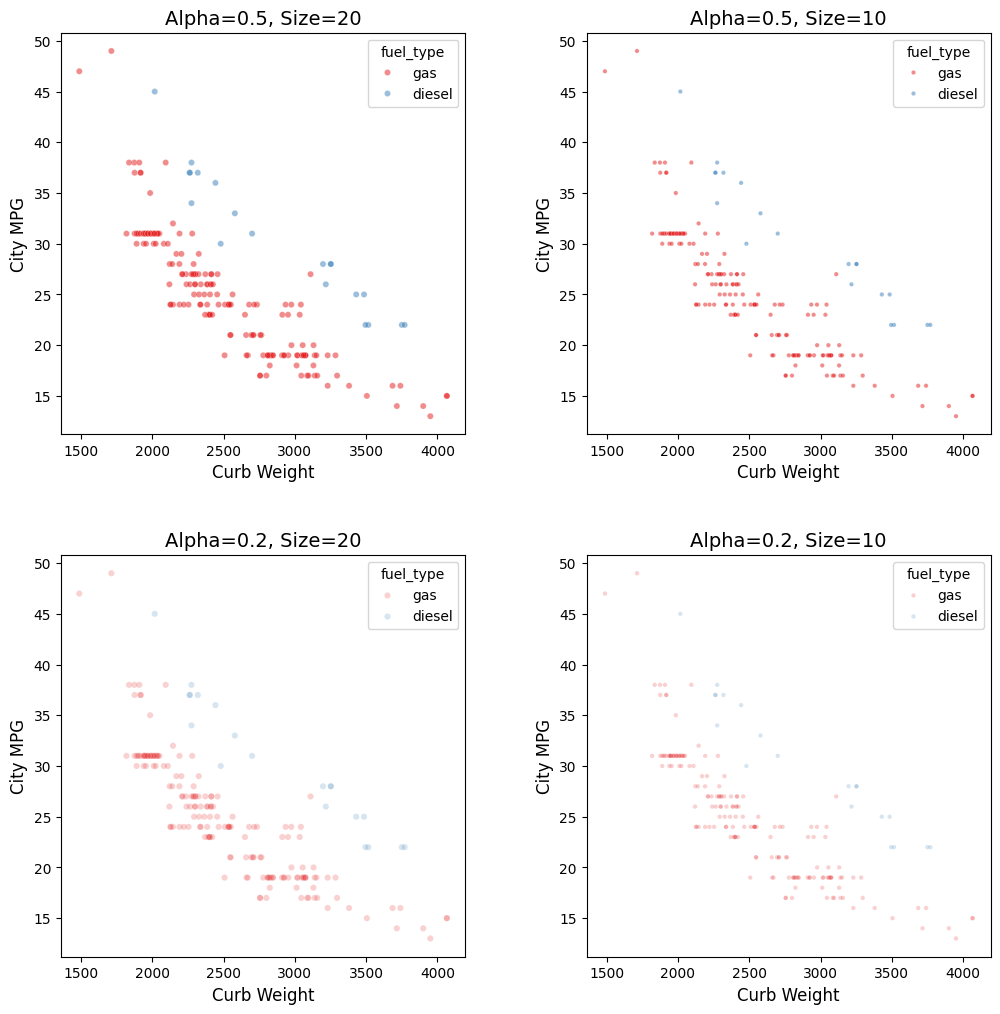

In [16]:
auto_price = pd.read_csv('/content/AutoPricesClean.csv')
print(auto_price.shape)

# Initial plot: Vehicle weight vs. City MPG, colored by fuel type
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x='curb_weight', y='city_mpg', hue='fuel_type', data=auto_price, palette="Set1")
ax.set_xlabel('Curb Weight', fontsize=14)
ax.set_ylabel('City MPG', fontsize=14)
ax.set_title('Vehicle weight vs. City MPG (Colored by Fuel Type)', fontsize=16)
plt.show()

# 2x2 array of plots with different alpha and size values to handle over-plotting
alpha_vals = [0.5, 0.2]
size_vals = [20, 10]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, alpha in enumerate(alpha_vals):
    for j, size in enumerate(size_vals):
        ax = axes[i, j]
        sns.scatterplot(x='curb_weight', y='city_mpg', hue='fuel_type', data=auto_price, palette="Set1",
                        alpha=alpha, s=size, ax=ax)
        ax.set_xlabel('Curb Weight', fontsize=12)
        ax.set_ylabel('City MPG', fontsize=12)
        ax.set_title(f'Alpha={alpha}, Size={size}', fontsize=14)

plt.show()


> Answer the following questions:    
> 1. Are all the data points still visible for all of these plots?
> 2. At the values of marker size and transparency selected, explain how your perception of the concetrated groups of vehicles in certian weight-city mpg ranges changes?  

> **Answer:**

> 1. Not really. In the plots with a higher transparency (alpha=0.2), some of the data points become super faint, especially when the markers overlap a lot. So yeah, while technically they're there, it's hard to see them clearly. On the other hand, when the markers are bigger (size=20), some points get covered up by others, especially in the denser areas. So, I'd say for most plots, it's easy to miss some of the overlapping points

> 2. With higher transparency (alpha=0.2), it's much easier to see through the overlapping points and figure out that there are a bunch of cars stacked on top of each other in certain weight-city mpg ranges, like the 2000-2500 curb weight and 20-30 MPG zone. But when the marker size is bigger, it becomes harder to tell where the concentration of vehicles is because the bigger markers cover more of the plot. So, when the markers are smaller and more transparent, I get a better sense of where the groups are really packed in.

## Other Scalable 2-d Plots     

2-d displays of one variable vs. another are key to understanding the relationships in complex datasets. We have just demonstrated that the combination of subsampling, marker size and marker transparency can improve one's ability to view data with larger numbers of closely spaced samples. However, it should be apparent that these methods have limitations and generally do not scale to very large datasets.

We will now examine three highly scalable methods for creating 2-d displays of large scale datasets. You have already seen one such plot type, the heatmap, in Chapter 5. Later in this chapter we will explore methods to create multi-dimensional views of complex data using multiple 2-d displays. In the big picture, the 2-d display is the building block for exploring more complex data.  

### Hex bin plot

The **hexbin plot** was developed by @Carr_1987, and is an alternative to a scatter plot. The hexbin plot is the 2-dimensional equivalent of the histogram. Whereas, a scatter plot uses a marker for each individual data value, a hexbin plot displays a 2-dimensional binning of these values. Hexagonal binning is used to minimize directional bias while maintaining close packing of the polygons. A sequential color palette is used to display the density of points in each hexagonal bin.   

The code below creates a hexbin plot of log median price vs. time using the [matplotlib.pyplot.hexbin](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html) function. The grid size is set to 50 x 50. A coarser grid than the default of 100 x 100. As with histograms, changing the grid size can change perception of the data relationships. Finding an effective grid size can require some experimentation for each specific case.  

A color bar with a label is added to the plot. The color bar is important for the viewer to interpret the point density in each bin.

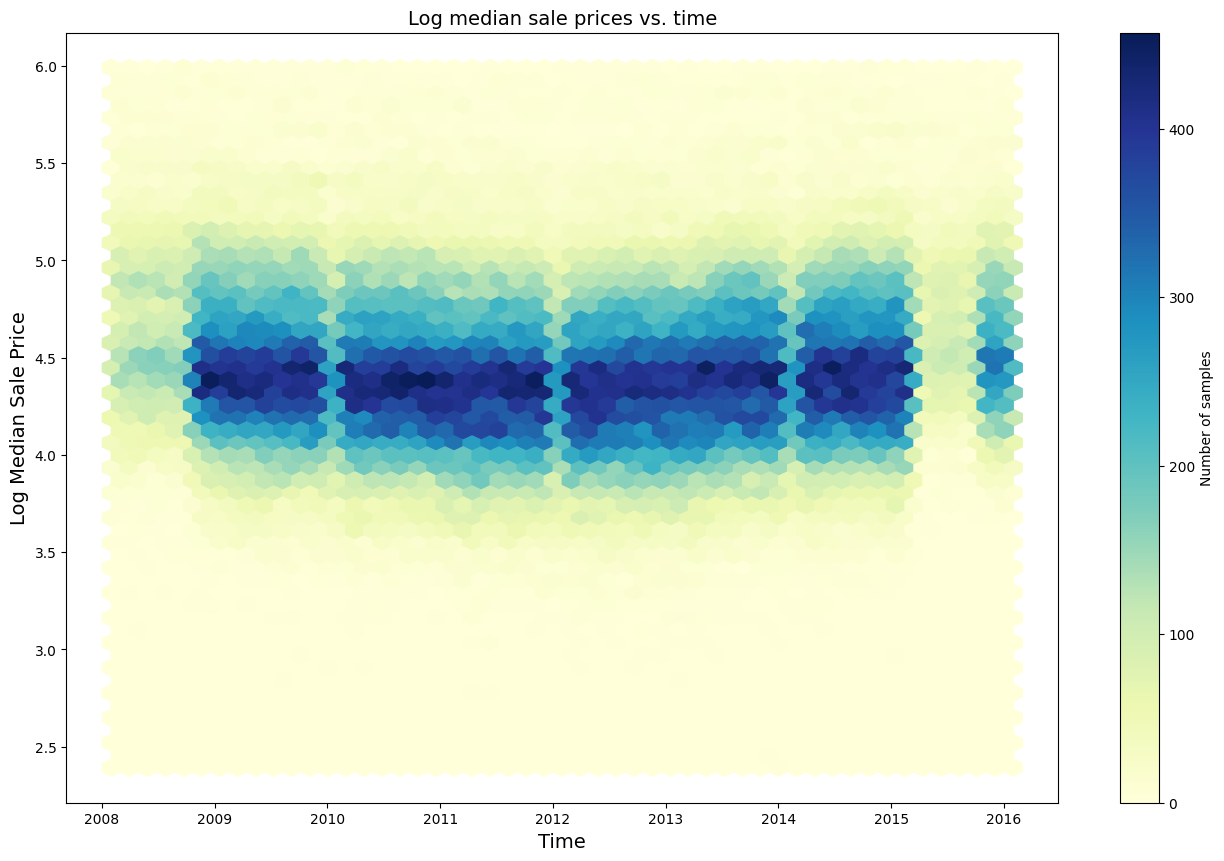

In [17]:
fig,ax = plt.subplots(figsize=(16,10))
p = plt.hexbin(x=housing.loc[:,'time_decimal'], y=housing.loc[:,'log_medSoldPriceSqft'], gridsize = 50, cmap='YlGnBu')
cb = plt.colorbar(p)
_=cb.set_label('Number of samples')
_=plt.xlabel('Time', fontsize=14)
_=plt.ylabel('Log Median Sale Price', fontsize=14)
_=plt.title('Log median sale prices vs. time', fontsize=14)
plt.show()

The hexbin plot is immune to over-plotting. This plot shows some distinct structure in the bulk of the data. One can see that the lowest prices for the bulk of sales are in about 2012 and increased thereafter. One can increase the resolution of a hexbin plot by using higher bin density.    

However, the hexbin plot losses some details. You cannot see the highest and lowest property values. Further, there are anomalies visible, caused by the discrete binning algorithm.

> **Computational efficiency of hexbin plotting:** Binning data values is a highly scalable process. Binning algorithms can be massively parallelized. As a result, hexbin plots can be created and displayed for massive data sets.     

> **Exercise 6-2:** In the previous exercise you created a scatter plot of vehicle weight vs. city MPG using various choices for marker size and transparency. Now, create a series of hexbin plots for the same variables. Use grid sizes of 15, 30 and 60. Make sure you include the grid dimension in the title of each plot.

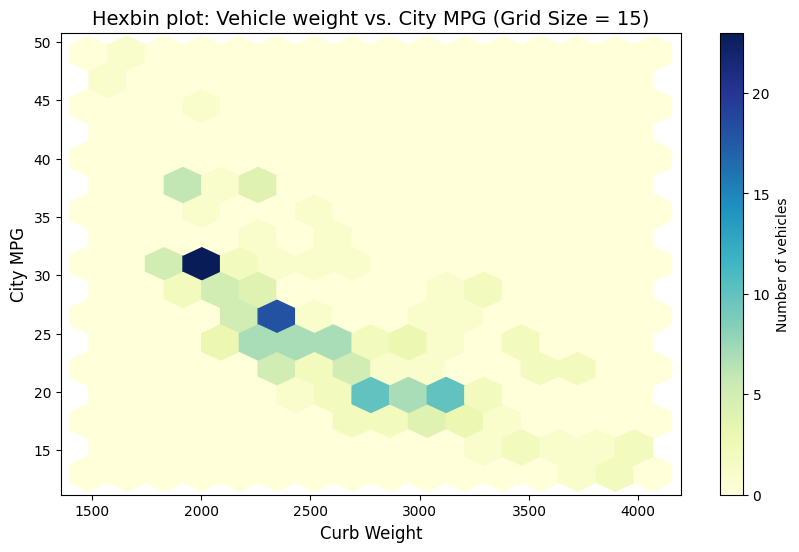

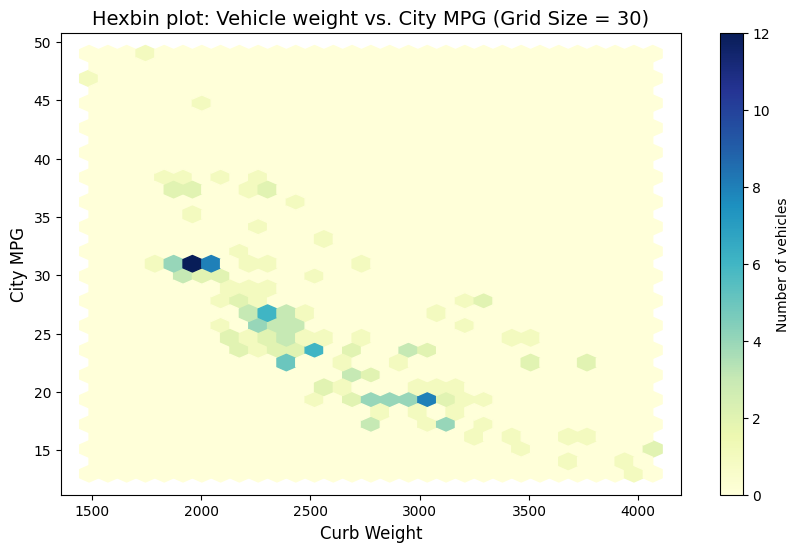

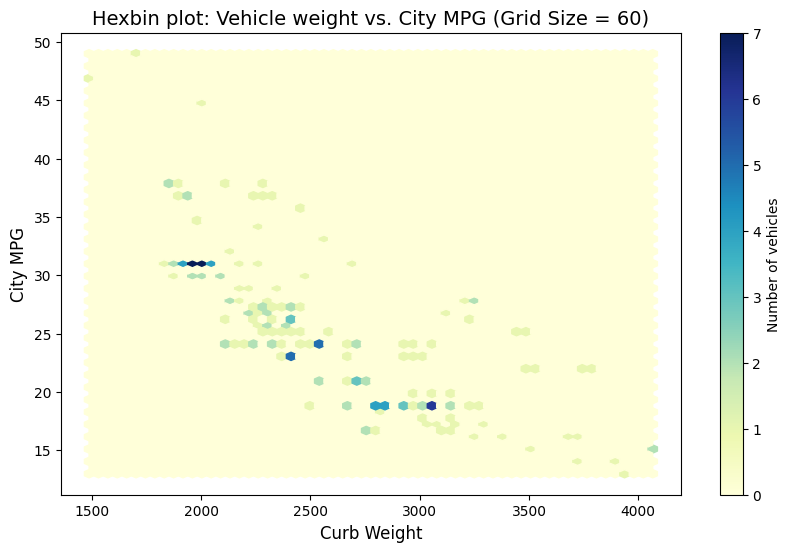

In [19]:
# Function to create and display hexbin plots
def hexbin_display(grid_dim):
    fig, ax = plt.subplots(figsize=(10, 6))
    p = ax.hexbin(x=auto_price['curb_weight'], y=auto_price['city_mpg'], gridsize=grid_dim, cmap='YlGnBu')
    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Number of vehicles')
    ax.set_xlabel('Curb Weight', fontsize=12)
    ax.set_ylabel('City MPG', fontsize=12)
    ax.set_title(f'Hexbin plot: Vehicle weight vs. City MPG (Grid Size = {grid_dim})', fontsize=14)
    plt.show()

# Create hexbin plots for grid sizes 15, 30, and 60
for grid_dim in [15, 30, 60]:
    hexbin_display(grid_dim)


> Examine your plots and answer the following questions by comparing the three hexbin plots as well as to the scatter plot you created by selecting values of marker size and transparency for Exercise 6-1:  
> 1. What aspects of the relationship are more apparent on these plots, compared to the scatter plots?
> 2. Which aspects are harder to see,  compared to the scatter plots?
> 3. How do the different grid sizes change your perception of the relationship?

> **Answers:**

> 1. In the hexbin plots, it's much easier to see where the data is concentrated. Like, you can instantly spot those darker blue hexagons that show where the majority of vehicles fall in terms of weight and MPG. In the scatter plot, everything overlaps, so it's hard to tell how many points are stacked on top of each other. But here, the density is super clear

> 2. One thing that's harder to see in the hexbin plots is the individual outliers or small groups of points. Since hexbin groups everything into bins, the specific data points... especially the ones that are more spread out or unique... get kind of lost in the mix. So, if there are any important outliers or patterns hidden in the scatter plot, those might be harder to notice here

> 3. With the smaller grid (like grid size 60), you see more detail and can even spot some subtle variations, but the overall density isn't as obvious. As you go to a coarser grid (like 15), it's easier to spot the overall trend, but you lose the fine detail. So, it's a trade-off: smaller grids show more resolution, while larger grids give you a clearer, big-picture view of where most of the data sits

### 2-D KDE plot

The 2-dimensional kernel density estimation (KDE) plot is another alternative to scatter plots. The 2-dimensional KDE plot is a natural extension of the 1-dimensional KDE plot algorithm discussed in Chapter 3. Once the density has been estimated, it is displayed as a contour plot.   

The code below computes and displays the 2-dimensional KDE plot of the log median price vs. time using the [seaborn.jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html) function. The default kernel span is used. Execute this code, which may take some time to run.     

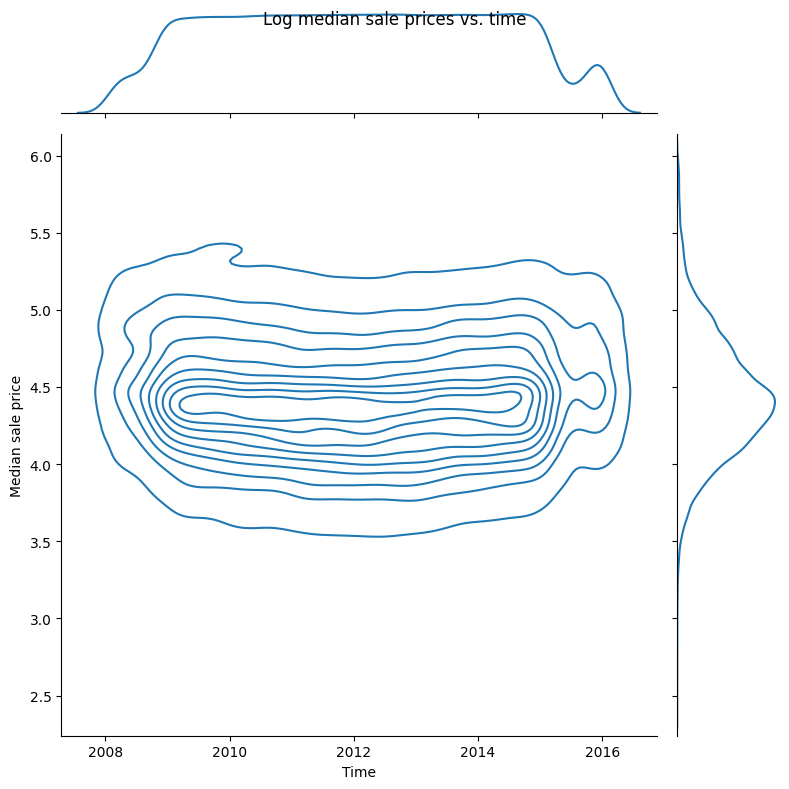

In [20]:
p=sns.jointplot(x='time_decimal', y='log_medSoldPriceSqft', data=housing, kind='kde', height=8)
p.set_axis_labels('Time','Median sale price')
p.figure.suptitle("Log median sale prices vs. time")
plt.show()

The information of this display is quite similar to the one created with the hexbin plot, as are the conclusions. Notice that the kernel density estimation and contouring process has a smoothing effect on the result.  

> **Computational efficiency of 2-d KDE plot:** The KDE plot algorithm is a two-step process. The first step is to compute the density using a 2-dimensional kernel. This step is computationally intensive, but can be parallelized. However, the second step, computing the contours of the density is hard to parallelize, but need only be run over the density estimates, not the raw data values. As a result, the 2-dimensional KDE plot can be scaled, but requires some effort to do so.

> **Exercise 6-3:** In the previous exercise you created a hexbin plot of vehicle weight vs. city MPG using various grid sizes. Now, create a 2-d KDE plots for the same variables setting the `bw_adjust` argument to each of $[0.25, 0.5, 1.0, 2.0]$. Make sure you state the bandwidth used in your plot title.  

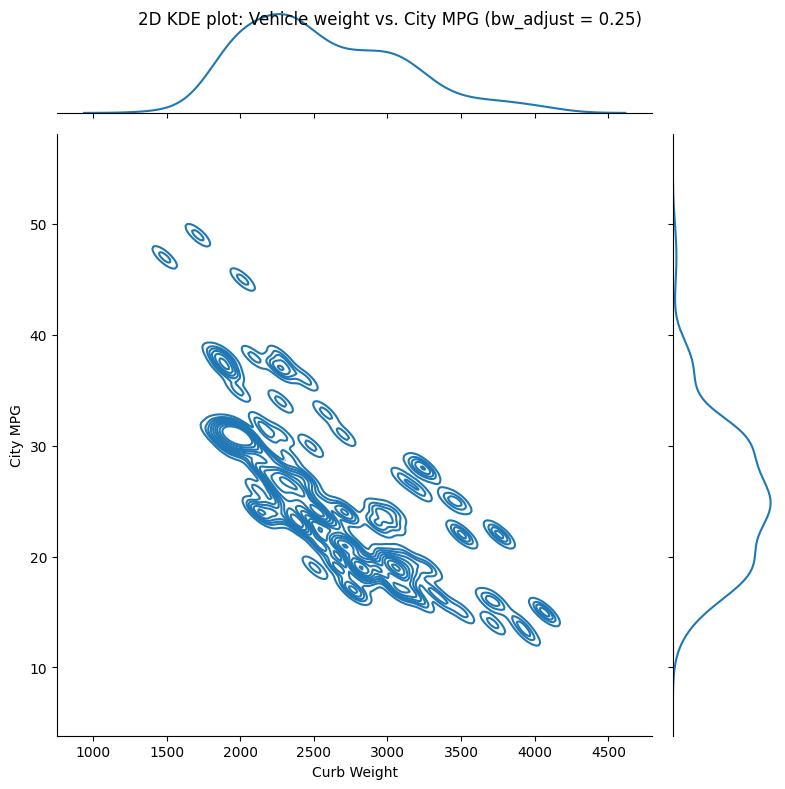

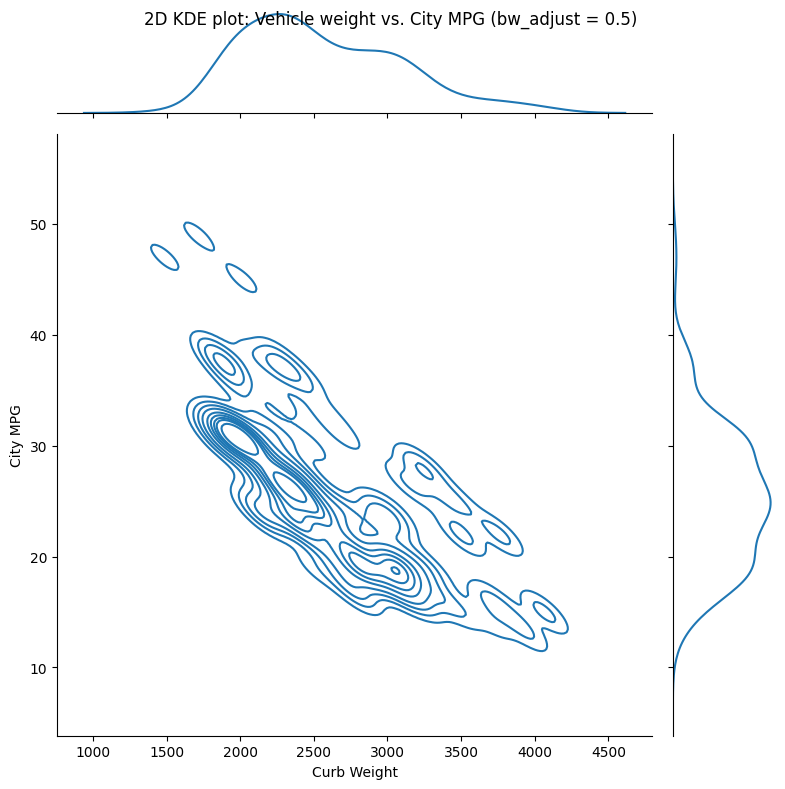

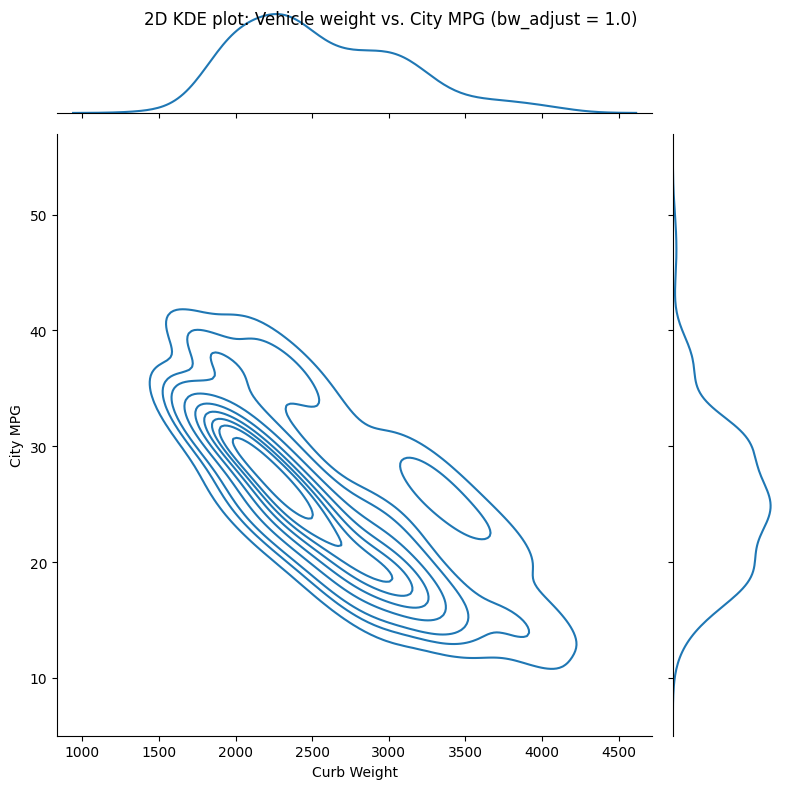

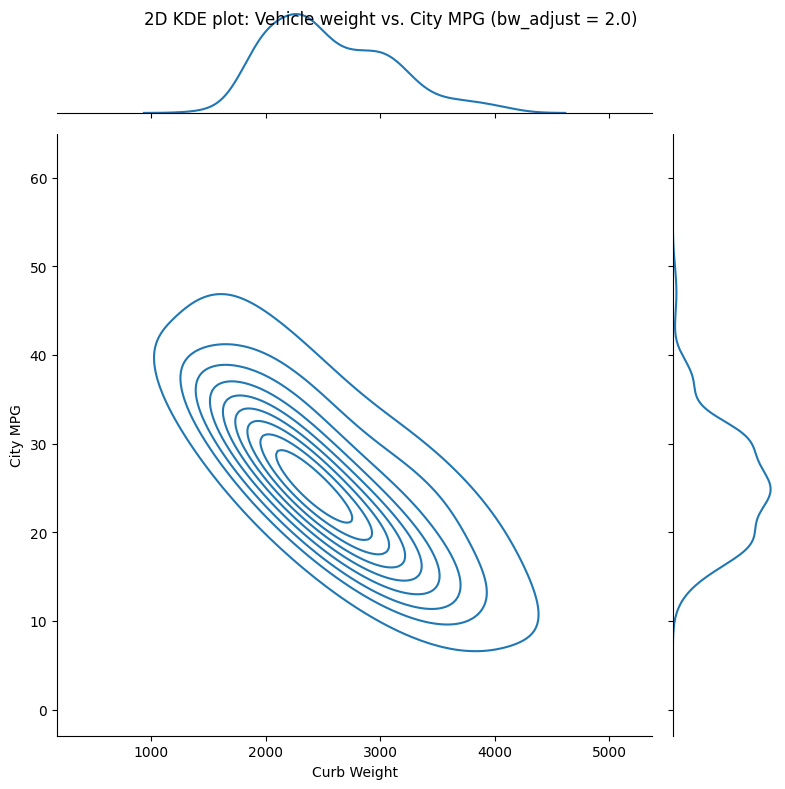

In [21]:
# Function to create and display 2D KDE plots with specified bandwidth
def kde_display(bw_value):
    p = sns.jointplot(x='curb_weight', y='city_mpg', data=auto_price, kind='kde', height=8, bw_adjust=bw_value)
    p.set_axis_labels('Curb Weight', 'City MPG')
    p.figure.suptitle(f'2D KDE plot: Vehicle weight vs. City MPG (bw_adjust = {bw_value})')
    plt.show()

# Create KDE plots for bw_adjust values 0.25, 0.5, 1.0, and 2.0
for bw_value in [0.25, 0.5, 1.0, 2.0]:
    kde_display(bw_value)


> Examine the density contour plots you just created and answer the following questions.  
> 1. How does changing the bandwidth of the kernel density estimator change your perception of the relationship between the variables?  
> 2. What aspects of the relationship are more apparent on all of these plots regardless of bandwidth changes when compared to the scatter plots?   
> 3. Which aspects of this relationship are harder to see regardless of bandwidth changes when compared to the scatter plots?    

> **Answers:**

> 1. The bandwidth affects how smooth or detailed the contours are. With a smaller bandwidth (like bw_adjust = 0.25), I see a lot of fine details in the data, like small clusters and subtle variations, but it can get a bit messy. As the bandwidth increases (like bw_adjust = 2.0), the plot becomes much smoother, and I can only see the big overall trend without much detail. So, with a smaller bandwidth, I get more precision, but with a larger one, I get a clearer big-picture view

> 2. The overall shape of the relationship between vehicle weight and city MPG is more obvious in these KDE plots compared to scatter plots. The contour lines make it really clear that heavier cars tend to have lower MPG, and lighter cars tend to have higher MPG. It's also easier to see where most of the data is concentrated because the density is shown in the contours, which isn't as easy to see with all the overlapping points in the scatter plot

> 3. Individual outliers and small clusters are harder to spot in these KDE plots, especially with the larger bandwidth. In the scatter plots, you can see each data point clearly, but with the KDE plots, some of those unique data points get smoothed out, and it's tough to tell if there are a few vehicles that don't follow the main trend


### Creative alternatives

In many cases, it is best to use a problem specific plot to display relationships in massive datasets. Often, one can find that workers in a specific domain have already developed such plots. In other cases, some creativity along with trial and error will be required to develop suitable plots. Here, we will create one such plot as an example

The time structure of this data suggests another way the relationship between log median price and time can be displayed. The data can be binned into time intervals, and the values in each bin displayed as a box plot.  

The code in the cell below does just this. The Pandas [cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) method is used to bin the data. The quarterly binned values are then displayed as a boxplot.

<ipython-input-22-05f1b62133bb>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


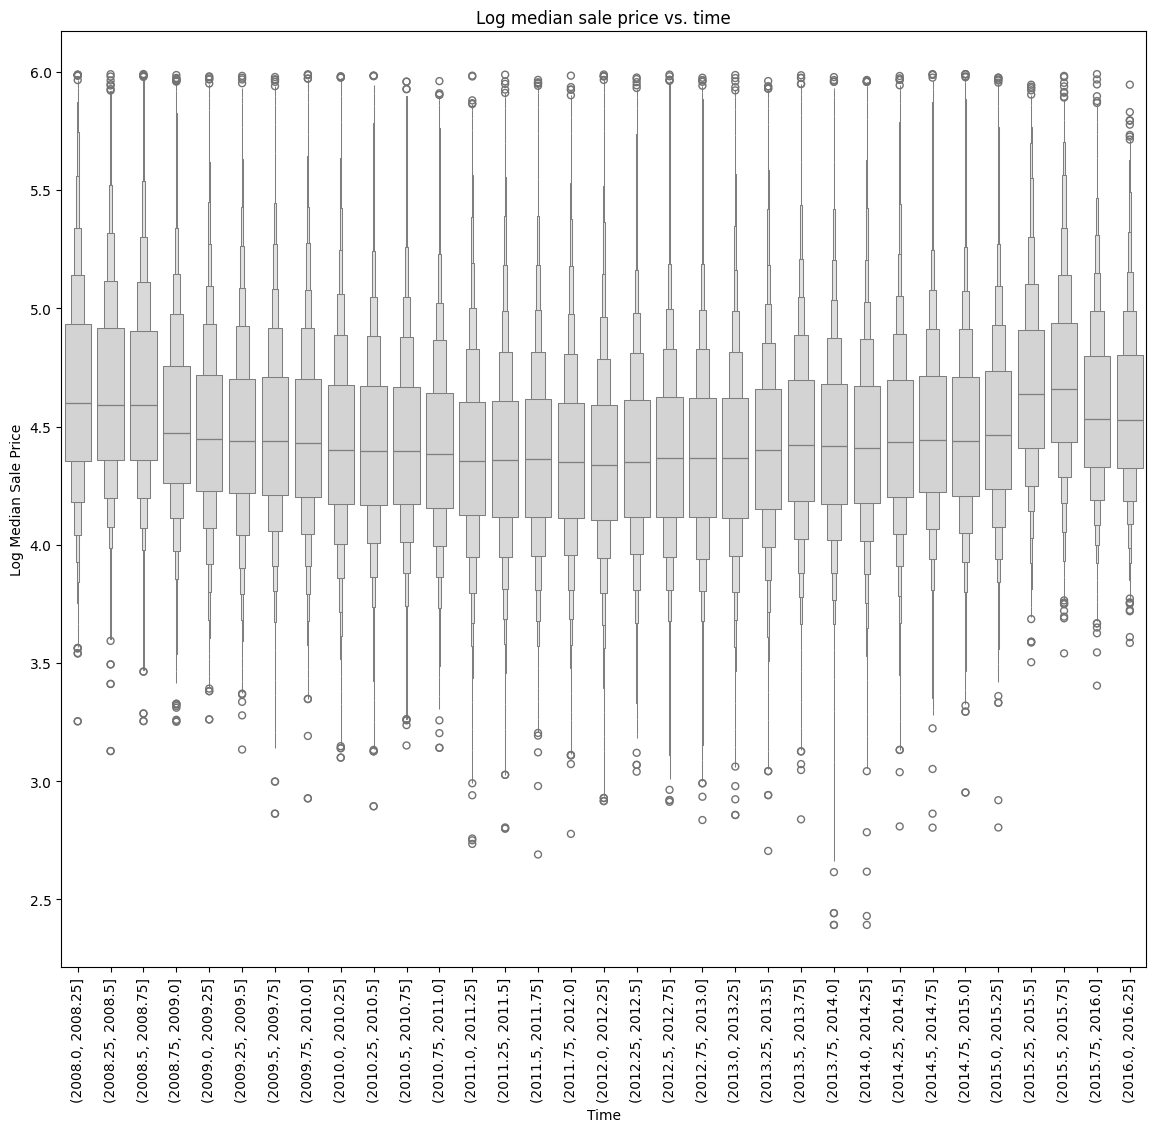

In [22]:
bins = [2008.0 + i * 0.25 for i in range(34)]
housing.loc[:,'time_bins'] = pd.cut(housing.loc[:,'time_decimal'], bins=bins)
fig, ax = plt.subplots(figsize=(14, 12))
fig.subplots_adjust(bottom=0.1)
_=sns.boxenplot(x='time_bins', y='log_medSoldPriceSqft', color='lightgray', data=housing)
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_=ax.set_title('Log median sale price vs. time')
_=ax.set_xlabel('Time')
_=ax.set_ylabel('Log Median Sale Price')

The resulting plot is interesting. For this type of plot, Seaborn uses a modified box plot. A number of quantiles are shown, creating a display between a conventional box plot and a violin plot.    

The time trend for the bulk of the values is clearly displayed by the median and middle 2 quartiles. Additional details can be seen by the division of the upper and lower quartiles into 5 intervals. Finally, the outliers, both high and low, can be clearly seen.

The low-value outliers do show that different filtering could be beneficial. The high-value outliers, on the other hand, are in a narrow range and are few in number, because of the filtering already applied.  

The foregoing demonstrates how a plot constructed for a specific situation can reveal important aspects of a relationship between variables. In this case, each of the standard methods shows some details at the expense of others. For example, the time-ordered boxplot shows considerable detail for each time bin. However, there is no way to perceive how many values are in each bin.  

> **Computational efficiency of ordered box plots:** The algorithm used in the example has 2 steps, both of which are fairly efficient. You can notice the short time required to render this plot. First, the data are binned by values of one or the other variables. As has already been discussed binning is a highly scalable process. Next, to create the box plots, the values in each bin must be sorted. Sorting tends to be less scalable. But the sorting of each bin is independent of the others, allowing parallel processing. The net result is quite a scalable method.  

> **Exercise 6-4:** To continue to explore the auto data, create ordered box plots of vehicle weight by city MPG bins. Use 2 and 4 MPG bins. Use `fuel_type` as the hue argument. Use the Seaborn boxplot function, to automatically manage the hue.

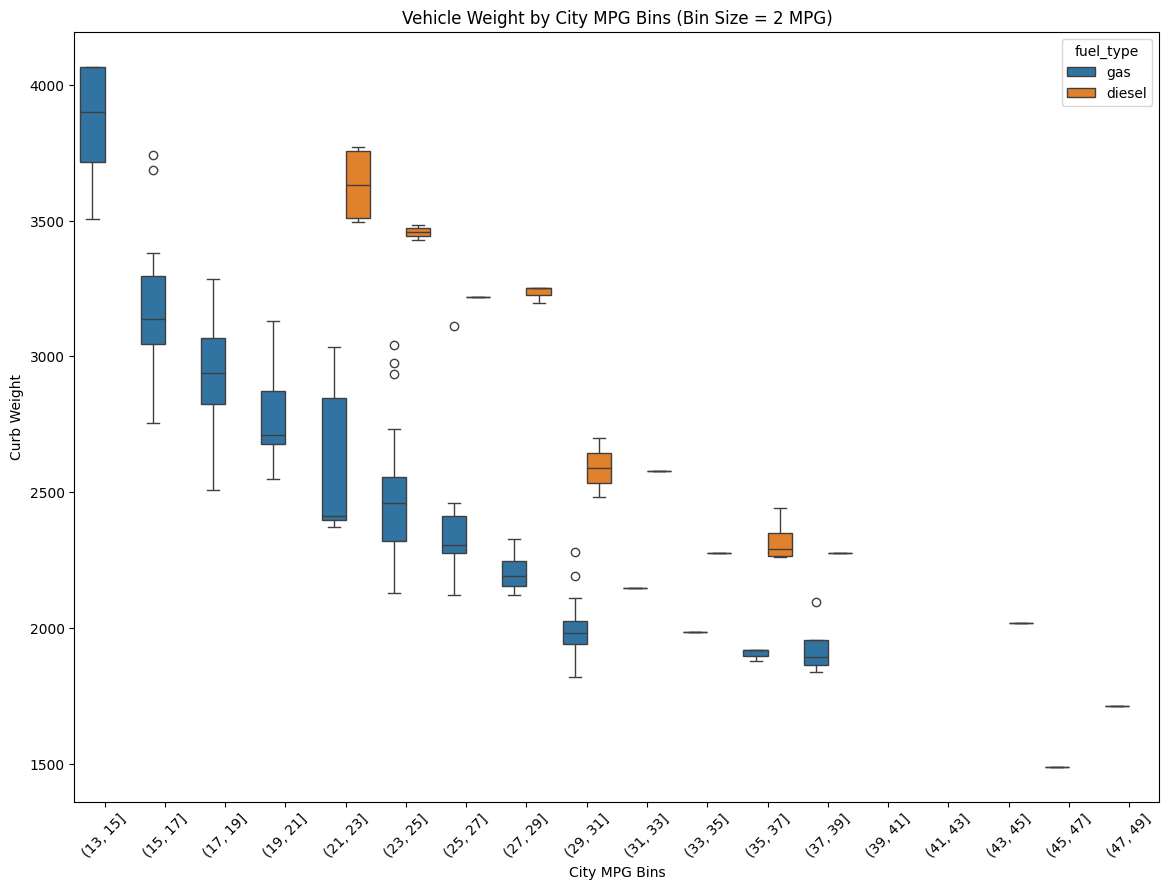

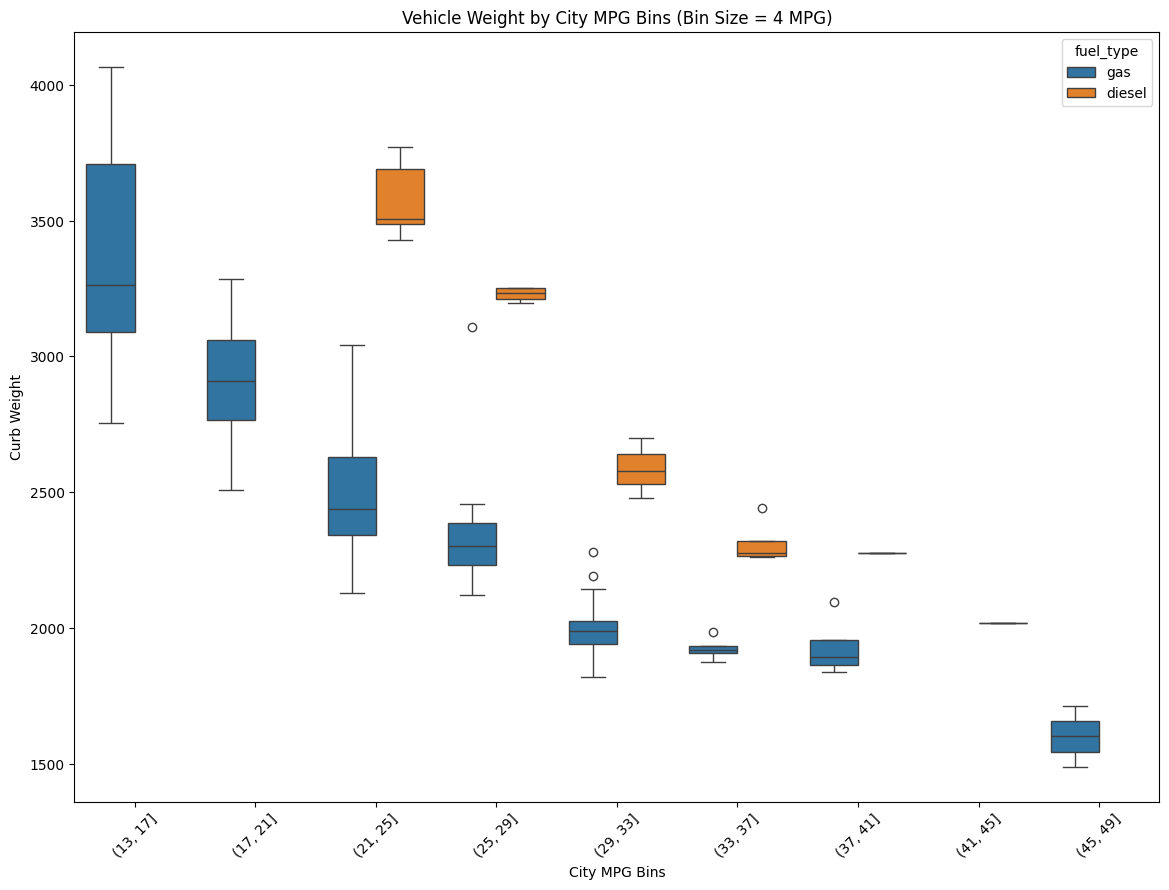

In [23]:
# Function to create and display box plots
def boxplot_display(bin_size):
    # Bin the city MPG data into the specified bin size
    mpg_bins = pd.cut(auto_price['city_mpg'],
                      bins=np.arange(auto_price['city_mpg'].min(),
                                     auto_price['city_mpg'].max() + bin_size, bin_size)
                      )

    fig, ax = plt.subplots(figsize=(14, 10))
    sns.boxplot(x=mpg_bins, y='curb_weight', hue='fuel_type', data=auto_price)
    ax.set_title(f'Vehicle Weight by City MPG Bins (Bin Size = {bin_size} MPG)')
    ax.set_xlabel('City MPG Bins')
    ax.set_ylabel('Curb Weight')
    plt.xticks(rotation=45)
    plt.show()

# Create box plots with 2 MPG and 4 MPG bins
for bin_size in [2, 4]:
    boxplot_display(bin_size)



> Examine your plot and answer these questions:  
> 1. How is your perception of the relationship between these variables different from the scatter plot?
> 2. How does using different bin widths change your perception of the relationships?

> **Answers:**

> 1. In the box plots, it's way easier to see how the weight of vehicles clusters within certain MPG ranges. You can really see the variation in vehicle weights for each MPG group and compare the range of weights for gas vs. diesel cars. The scatter plot didn't make it as clear where most of the cars fall in terms of weight within each MPG group, because all the points were overlapping. The box plot gives you a more structured view, especially for seeing the medians, ranges, and any outliers

> 2. With the 2-MPG bins, you can see more detail and more variation within smaller ranges, which gives a better picture of how weights are distributed for very specific MPG values. On the other hand, the 4-MPG bins smooth things out a bit more, so you lose some of that fine-grained detail, but it's easier to see the overall trend across larger groups of cars. The 4-MPG bins also group things together more, so the differences between gas and diesel cars aren't as distinct as with the 2-MPG bins


## Data Set For Examples

To demonstrate the concept of facet plotting, we will use another data set. @Fanaee-T created this data set, which contains an aggregated counts of hourly rentals in the Washington D.C. bicycle sharing system. There are 2 years of hourly values, or 17389 time ordered cases. While not large or highly complex by modern standards, this data set is useful to illustrate the concepts of faceting for plots. The variables in this data set are:     
1. instant: record index     
2. dteday : date    
3. season : season (1:winter, 2:spring, 3:summer, 4:fall)   
4. yr : year (0: 2011, 1:2012)    
5. mnth : month ( 1 to 12)   
6. hr : hour (0 to 23)   
7. holiday : day is holiday or not (extracted from [Web Link])   
8. weekday : day of the week   
9. workingday : if day is neither weekend nor holiday is 1, otherwise is 0.   
10. weathersit:   
   - 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
   - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist   
   - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
11.temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)    
12. atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)    
13. hum: Normalized humidity. The values are divided to 100 (max)    
12. windspeed: Normalized wind speed. The values are divided to 67 (max)   
13. casual: count of casual users   
14. registered: count of registered users    
15. cnt: count of total rental bikes including both casual and registered     

The goal of the analysis is to predict the number of bikes in use for each hour of the day, the 'cnt' variable, using the independent variables. There are a great many relationships one can investigate in this data set. In this example we will use facet plotting to investigate.

The code below performs the following operations:  

1. loads the data set.   
2. A new column is created in the data frame with a human readable month abbreviations. These abbreviations come from the [Python calendar package](https://docs.python.org/3/library/calendar.html).        
3. Create a column with human readable weather conditions using a simple Python dictionary lock-up.  
4. Display a list of the column names and types.   

In [25]:
bike_share_df = pd.read_csv('/content/BikeSharing.csv')

## Add month column with names
bike_share_df.loc[:,'month'] = [calendar.month_abbr[i] for i in bike_share_df.loc[:,'mnth']]

## Add column with human readable weather conditions
weather = {1:'Clear', 2:'Mist', 3:'Light precipitation', 4:'Heavy precipitation'}
bike_share_df.loc[:,'Weather'] = [weather[i] for i in bike_share_df.loc[:,'weathersit']]

## Display the data column names and types
bike_share_df.dtypes


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
month          object
Weather        object
dtype: object

### Mosaic plots   

The foregoing scalable plot types are used primarily for numeric data. But, how can we display multidimensional count (categorical) data at scale? There is no perfect answer. The **mosaic plot** is one possible answer.   

The origin of the mosaic plot is not entirely clear. This plot type has been used for applications in physiology for some time, @Friendly_1992, @Friendly_1994, and @Friendly_2001.

The mosaic displays the relative proportion of counts of a contingency table. The plot area is divided in to a set of tiles that fully fill the plot area. The larger the count, the larger the area of the tile on the plot.    

The concept of the mosaic plot is best understood by seeing an example. The code in the cell below creates a mosaic plot using the [statsmodels.graphics.mosaicplot.mosaic](https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html) function to create an example using the bicycle rental data. This function uses counts by category, and therefore requires categorical variables. The first six lines of the the code below creates categorical variables with human understandable names.        


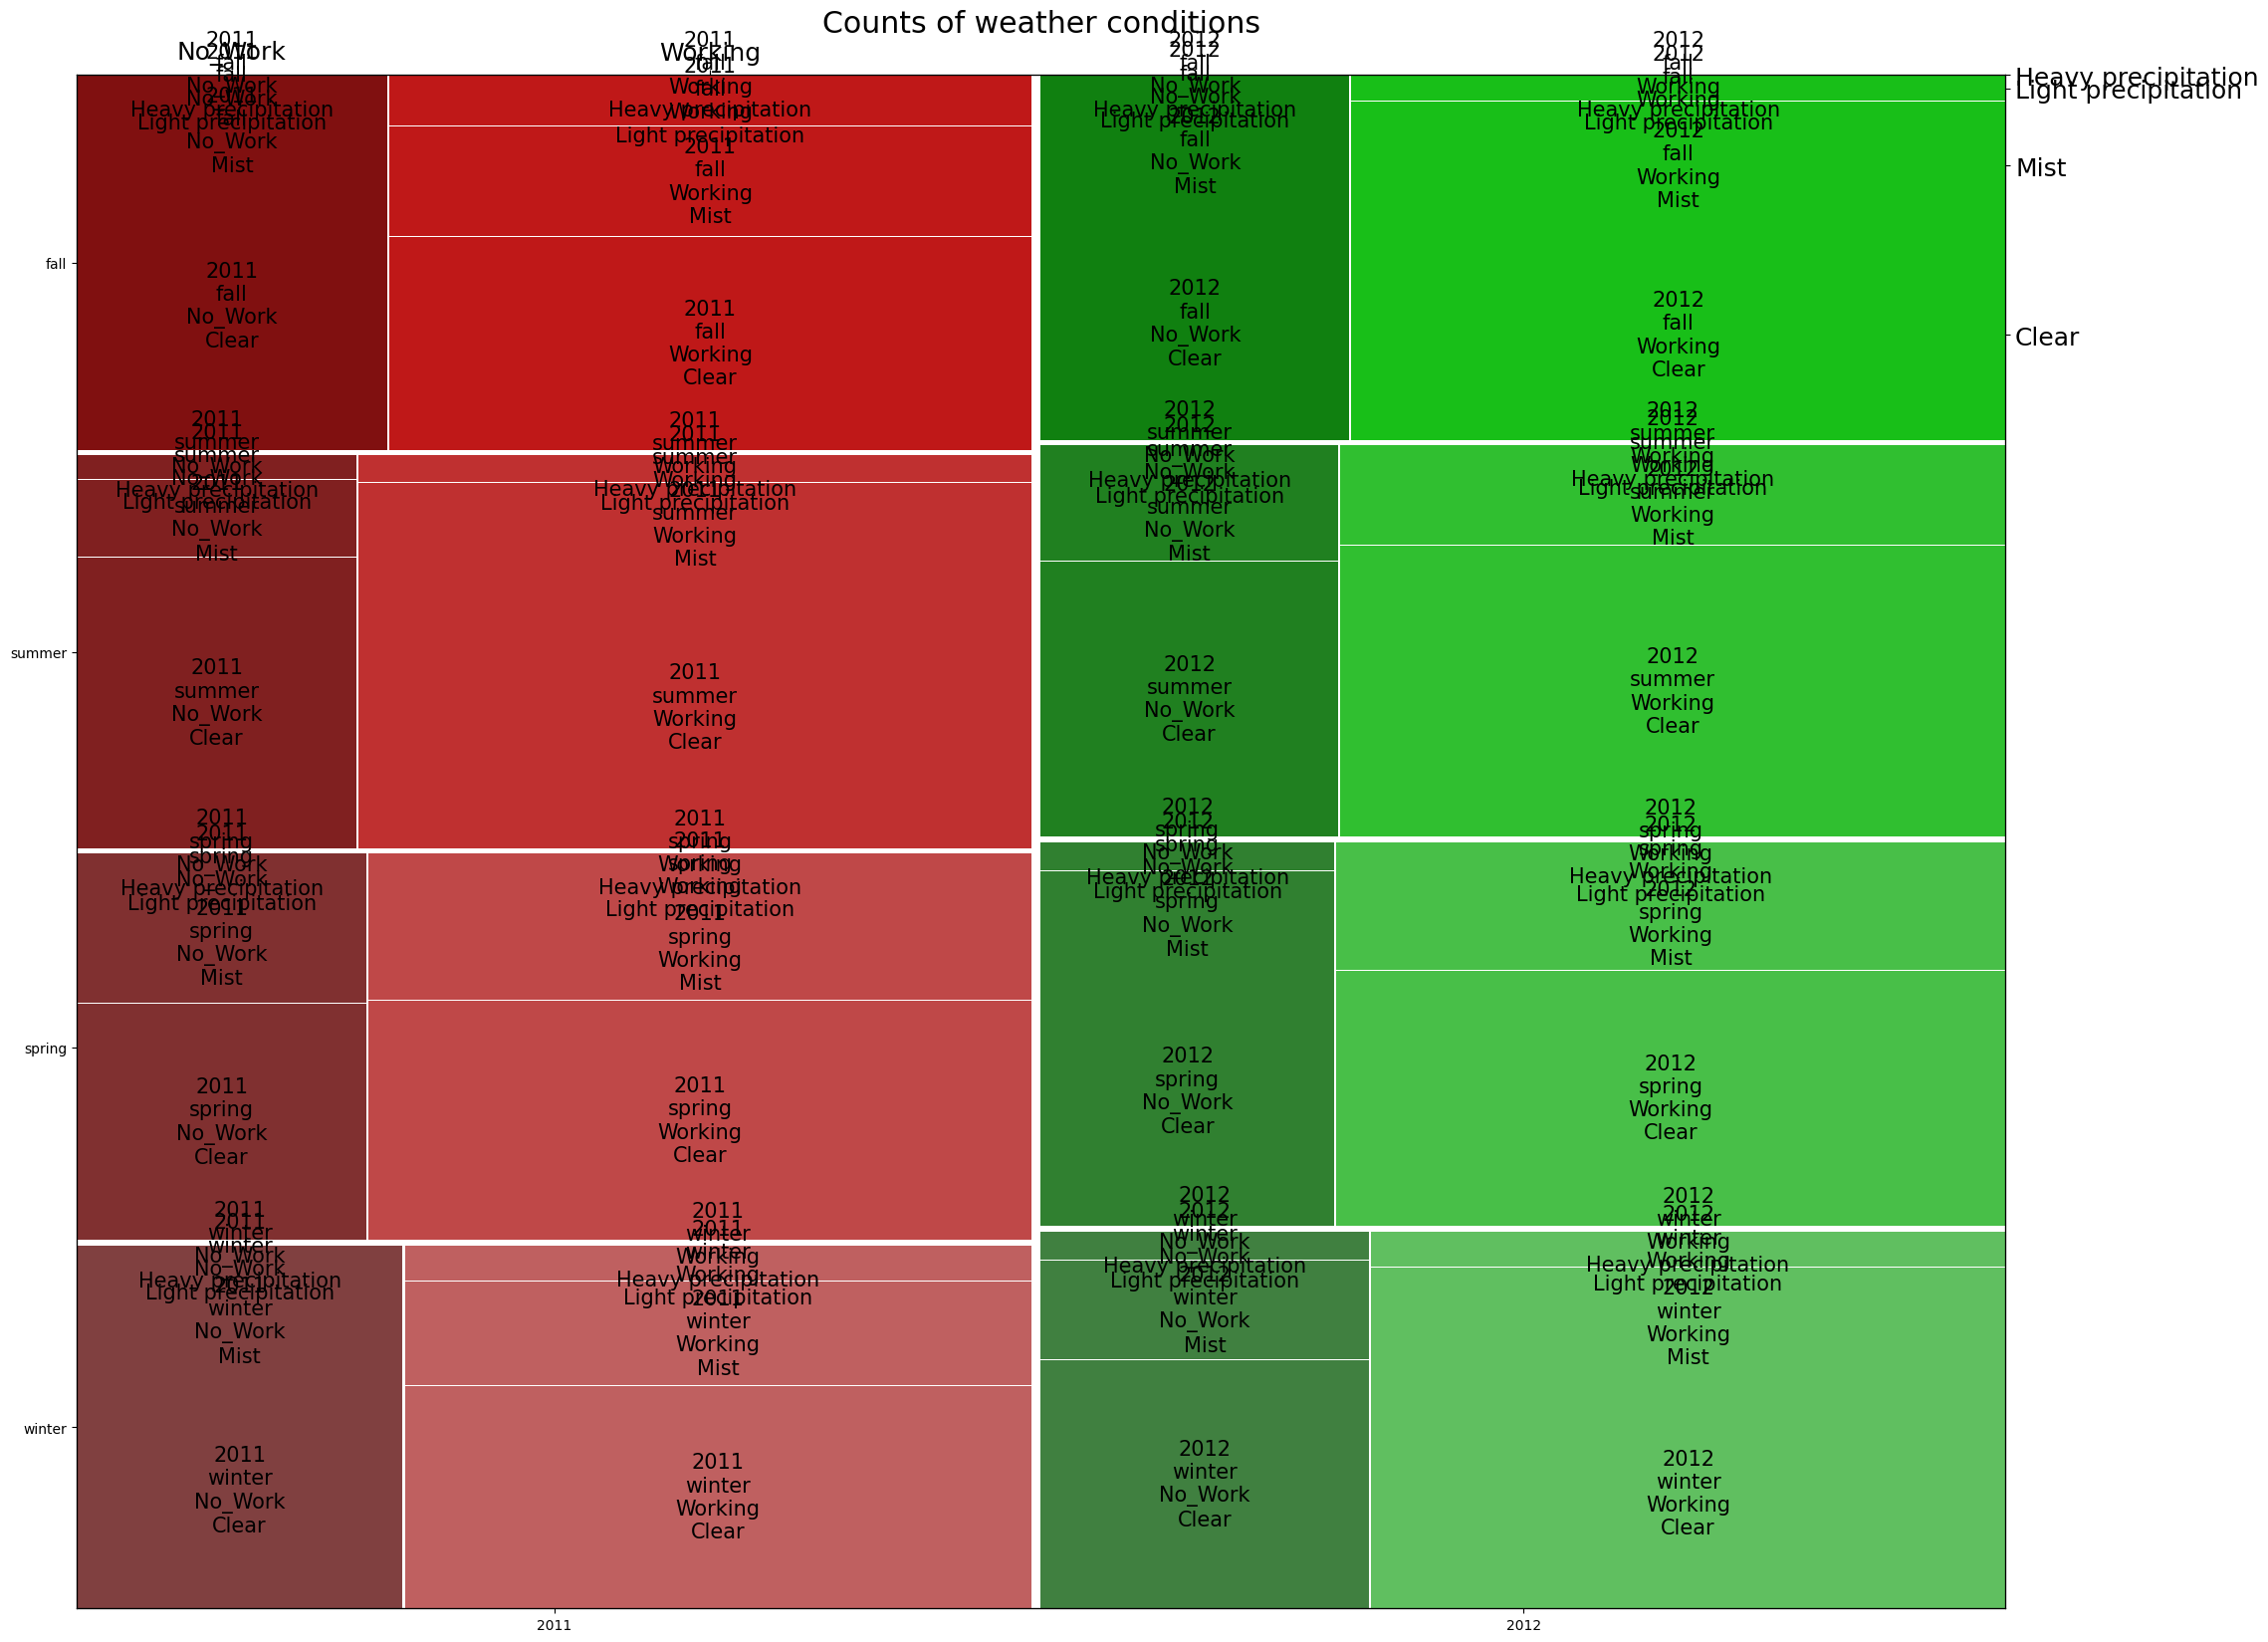

In [26]:
season = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}
bike_share_df.loc[:,'Season'] = [season[i] for i in bike_share_df.loc[:,'season']]
year = {0:'2011', 1:'2012'}
bike_share_df.loc[:,'year'] = [year[i] for i in bike_share_df.loc[:,'yr']]
working = {0:'No_Work', 1:'Working'}
bike_share_df.loc[:,'WorkingDay'] = [working[i] for i in bike_share_df.loc[:,'workingday']]

categorical_cols = ['year','Season', 'WorkingDay', 'Weather']


fig, ax = plt.subplots(figsize=(25, 20))
plt.rcParams.update({'font.size': 18})
_=mosaicplot.mosaic(bike_share_df.loc[:,categorical_cols],
                    index=list(categorical_cols),
                    title = 'Counts of weather conditions',
                    ax=ax)

plt.show()


The relative counts for each unique combination of the categorical variables are displayed as the area of the tiles on the plot area. The tiles are laid out as follows:    

- The seasons of the year are on the vertical axis.   
- Year and working day status are on the horizontal axis.   
- Each combination of season, year and working day status are divided by the 4 possible weather conditions.    

Study the relative areas of the tiles on this plot. There are a number of observations one can make. Some are obvious, such as the smaller number of non-working days each year. Others require a bit more thought, such as the differences in days with each weather conditions by year and season.  

## Another sample data set

We will now introduce another data set, which has information on 442 diabetes patients. These data come from @Efron_etal_2004. This data set has enough complexity to demonstrate some principles of exploring relationships in complex data sets.  

There are 10 numeric independent variables or features in the data set. This data set is described in the [ScikitLearn data sets User Guide](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset).:    
- Age
- Sex
- Body mass index
- Average blood pressure
- S1, tc, T-Cells (a type of white blood cells),  
- S2, ldl, low-density lipoproteins,    
- S3, hdl, high-density lipoproteins,   
- S4, tch, thyroid stimulating hormone,   
- S5,  ltg, lamotrigine,   
- S6 glu, blood sugar level.

S1 to S6 are blood serum measurements. The dependent variable or label is a numerical score of Disease Progression.    

All of the variables are numeric, including the independent variable. Further, the dependent variables have already been scaled to have zero mean and unit variance.

The code below loads the data set from [sklearn.datasets.load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html). The `load_diabetes` function returns separate NumPy arrays for the independent and dependent variables. A Pandas data frame, including column names, is created from these NumPy arrays. A categorical column for the `Sex` variable is then created.

In [27]:
## Load the data arrays
diabetes_X, diabetes_y = load_diabetes(return_X_y=True)
## Create a data frame with the correct column names for the independent variables.
column_names = ['Age','Sex','BodyMassIndex','AverageBloodPressure','S1','S2','S3','S4','S5','S6']
diabetes = pd.DataFrame(diabetes_X, columns=column_names)
## Add the dependent variable to the data frame and set it to categorical type
diabetes.loc[:,'DiseaseProgression'] = diabetes_y
diabetes.loc[:,'sex_categorical'] = diabetes.loc[:,'Sex'].map(lambda x: 'male' if x<0 else 'female')
diabetes.head()


Age       Sex  BodyMassIndex  AverageBloodPressure        S1  \
0  0.038076  0.050680       0.061696              0.021872 -0.044223   
1 -0.001882 -0.044642      -0.051474             -0.026328 -0.008449   
2  0.085299  0.050680       0.044451             -0.005670 -0.045599   
3 -0.089063 -0.044642      -0.011595             -0.036656  0.012191   
4  0.005383 -0.044642      -0.036385              0.021872  0.003935   

         S2        S3        S4        S5        S6  DiseaseProgression  \
0 -0.034821 -0.043401 -0.002592  0.019907 -0.017646               151.0   
1 -0.019163  0.074412 -0.039493 -0.068332 -0.092204                75.0   
2 -0.034194 -0.032356 -0.002592  0.002861 -0.025930               141.0   
3  0.024991 -0.036038  0.034309  0.022688 -0.009362               206.0   
4  0.015596  0.008142 -0.002592 -0.031988 -0.046641               135.0   

  sex_categorical  
0          female  
1            male  
2          female  
3            male  
4            male

Let's check for missing values.

In [28]:
for col in diabetes.columns:
    missing = diabetes.loc[:,col].isnull().sum()
    print('For {} the number of missing values = {}'.format(col,missing))

For Age the number of missing values = 0
For Sex the number of missing values = 0
For BodyMassIndex the number of missing values = 0
For AverageBloodPressure the number of missing values = 0
For S1 the number of missing values = 0
For S2 the number of missing values = 0
For S3 the number of missing values = 0
For S4 the number of missing values = 0
For S5 the number of missing values = 0
For S6 the number of missing values = 0
For DiseaseProgression the number of missing values = 0
For sex_categorical the number of missing values = 0


There are no missing values we need to deal with in this dataset.  

## Understanding relationships in complex data

As has already been stated, it is typically the case that complexity, not size, presents the greatest challenge in data exploration. In this section we will examine some methods for finding and understanding relationships in complex data.

In general, understanding complex data is done by understanding the relationship in simpler subsets. The key idea is that often it is better to have a larger number of simpler plots showing different projections or subsets of a data set than a few complex and hard to perceive charts. Complex charts with many colors, markers, line types, etc., and displaying a large number of data values, can be confusing at best and impossible to understand at worse. An overall understanding is obtained by examining charts of subsets. Ultimately the key relationships in the data can be found and understood.   

In the preceding chapter, we investigated using different aesthetics to project multiple dimensions of a data set onto a 2-dimensional plot. These techniques can be applied just as well to subsets of a larger data set.       

There are many possibilities for showing subsets and projections of complex data. We will use three of these.    
1. **Arrays of plots:** Plots of subsets can be used to show relationships in a complex data set. We have already seen examples of side-by-side box plots and violin plots. These plots show differences in the empirical distribution of the subsets of a larger data set. The same principle can be used to show an array of plots. We have used this approach with the Seaborn 2-dimensional `distplot` which shows the histograms along each axis. We will use arrays of plots extensively in subsequent chapters.           
2. **Pairwise scatter plots** comprise a matrix of all pairwise combinations of variables. Other relationships and plot aesthetics can be added to these plots. Further, pairwise scatter plots can be created for subsets of large and complex data sets.     
3. **Faceting** involves using values of categorical or numeric variables to create subsets of a data set. The subsets are displayed on an array of plots showing each of the subsets. Faceting goes by several other monikers, including **conditional plotting**, the **method of small multiples** or **lattice plotting**. All of these methods use axes with the same scale. Using the same scale is important to ensure correct perception of the relationships in the data.   

Notice that methods 2 and 3 above are special cases of method 1.   

> **Grid plots with Seaborn:** To assist in making arrays of plots, Seaborn has a special grid object. The grid is an array of sub-plots on a Matplotlib figure. Each of the sub-plots areas is filled with a plot of some type. Most any Python plot function can be used, including a custom function you create. As a result, the Seaborn grid has significant flexibility. You will see examples of applying the grid to Seaborn plots below.  

### The scatter plot matrix   

The **scatter plot matrix** is a useful display for investigating the relationships between a number of variables. The scatter plot was first published by @Chambers_1983, but is known to have been in use previously.

The basic idea for the scatter plot matrix is to display a scatter plot of each variable versus all other variables, arranged in an array. Each pairwise relationship is displayed twice. Once above and once below the diagonal. In this way, the two possible orientations of each variable pair is displayed.    

Seaborn provides a choice of plot types on the grid or array. Plots can be specified for the upper and lower halves of the array. Additionally, the diagonal of the scatter plot matrix can be filled by another plot type. Typically, a distribution plot is used on the diagonal.      

Let's try an example. The code below does the following:    
1. Creates a grid object with the Seaborn [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html) function. Notice that `Sex` column is dropped from the data frame, since it is redundant with the `sex_categorical` column.   
2. The `map_upper` and `map_lower` methods map plots those parts the grid object. Notice that arguments to the selected plot functions are passed through call to 'map'.
3. In a similar way the plots on the diagonal are created using the `map_diag` method on the grid object.

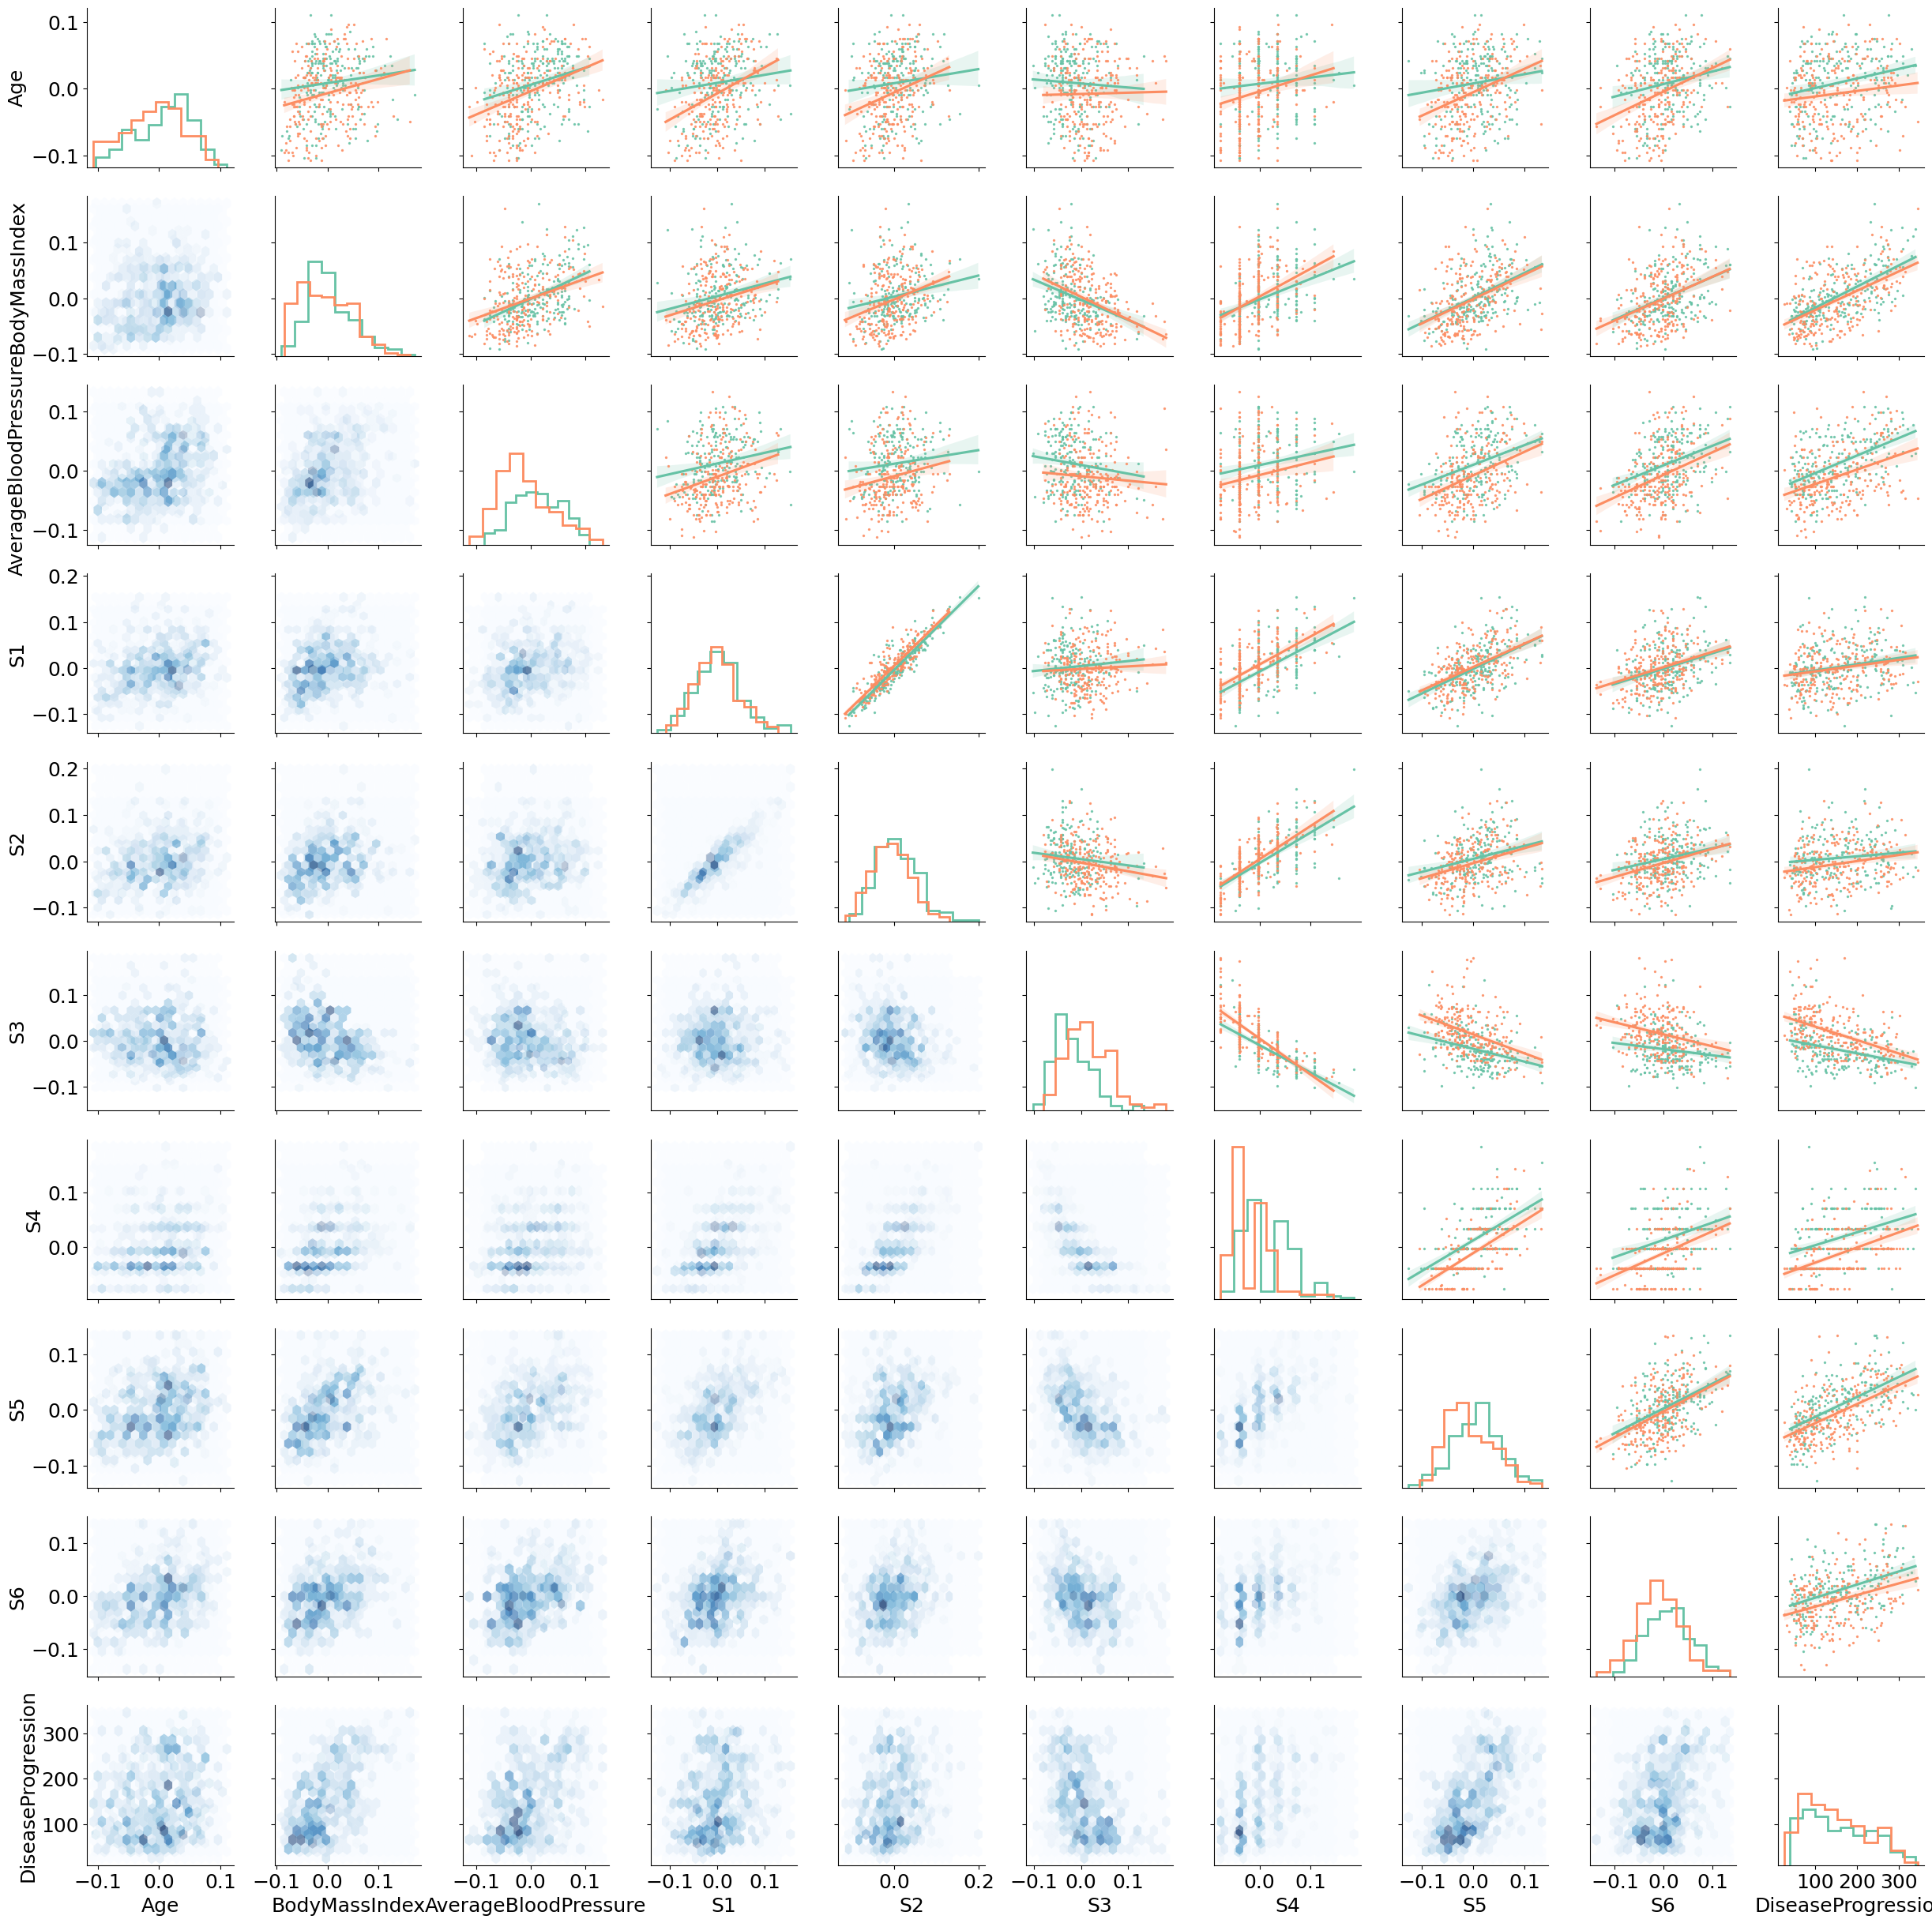

In [29]:
g = sns.PairGrid(diabetes.drop('Sex', axis=1), hue='sex_categorical', palette="Set2")
_=g.map_upper(sns.regplot, order=1, truncate=True, scatter_kws={'s':2})
_=g.map_lower(plt.hexbin, alpha=0.5, cmap='Blues', gridsize=15, linewidths=0)
_=g.map_diag(plt.hist, histtype="step",linewidth=2)
plt.show()


Fully interpreting this scatter plot matrix takes some effort. There are many details about the relationships one can notice in such a plot. While there is no perfect approach, it is often helpful to view such a plot in the following order:    
1. Look down the diagonal and note the distributions of the variables. Which ones are symmetric? If they are skewed, is the skew to the right or the left? Are there significant differences between the subsets shown?   
2. Look at the relationships between the variables in the columns and each of the other variables in the rows. Is there a noticeable relationship between the variables displayed?   
3. Look at the relationships between each variables in the rows and each of the other variables in the columns. Try to put your focus on the relationships that seemed most interesting in step 2.  
4. Use subsets of the data to reduce complexity of the plot, improving the viewer's ability to interpret the plot. Ideally, the subsets are selected to show the most interesting relationships. Interesting subsets can be selected manually or using a statistical filter, or cognostic, as discussed in a section below.   

Specifically for the plot displayed, one can make several observations, including the following:    
1. Most of the relationships do not appear particularly strong.    
2. Several of the independent variables appear to have a possible predictive relationship with the Disease Progression dependent variable.    
4. Serum measurements S1 and S2 are nearly colinear.  
3. The S4 serum measurement has discrete values. This leads to over-plotting. We will address this problem in the next subsection.  

> **Exercise 6-5:** To improve the understandability of the plot a subset of the variables can be used. The variables 'Age', 'S1' and 'S2' appear to have the smallest slopes with respect to the disease progression score. Create a new scatter plot matrix **without** these variables. Use the Seaborn `regplot` function for both the upper and lower parts of the matrix. Add alpha=0.3 to the `scatter_kws` dictionary. Otherwise, use the same arguments for the scatter plots as before. Retain the histogram plots on the diagonal of the matrix. This approach displays each relationship in both possible orientation.

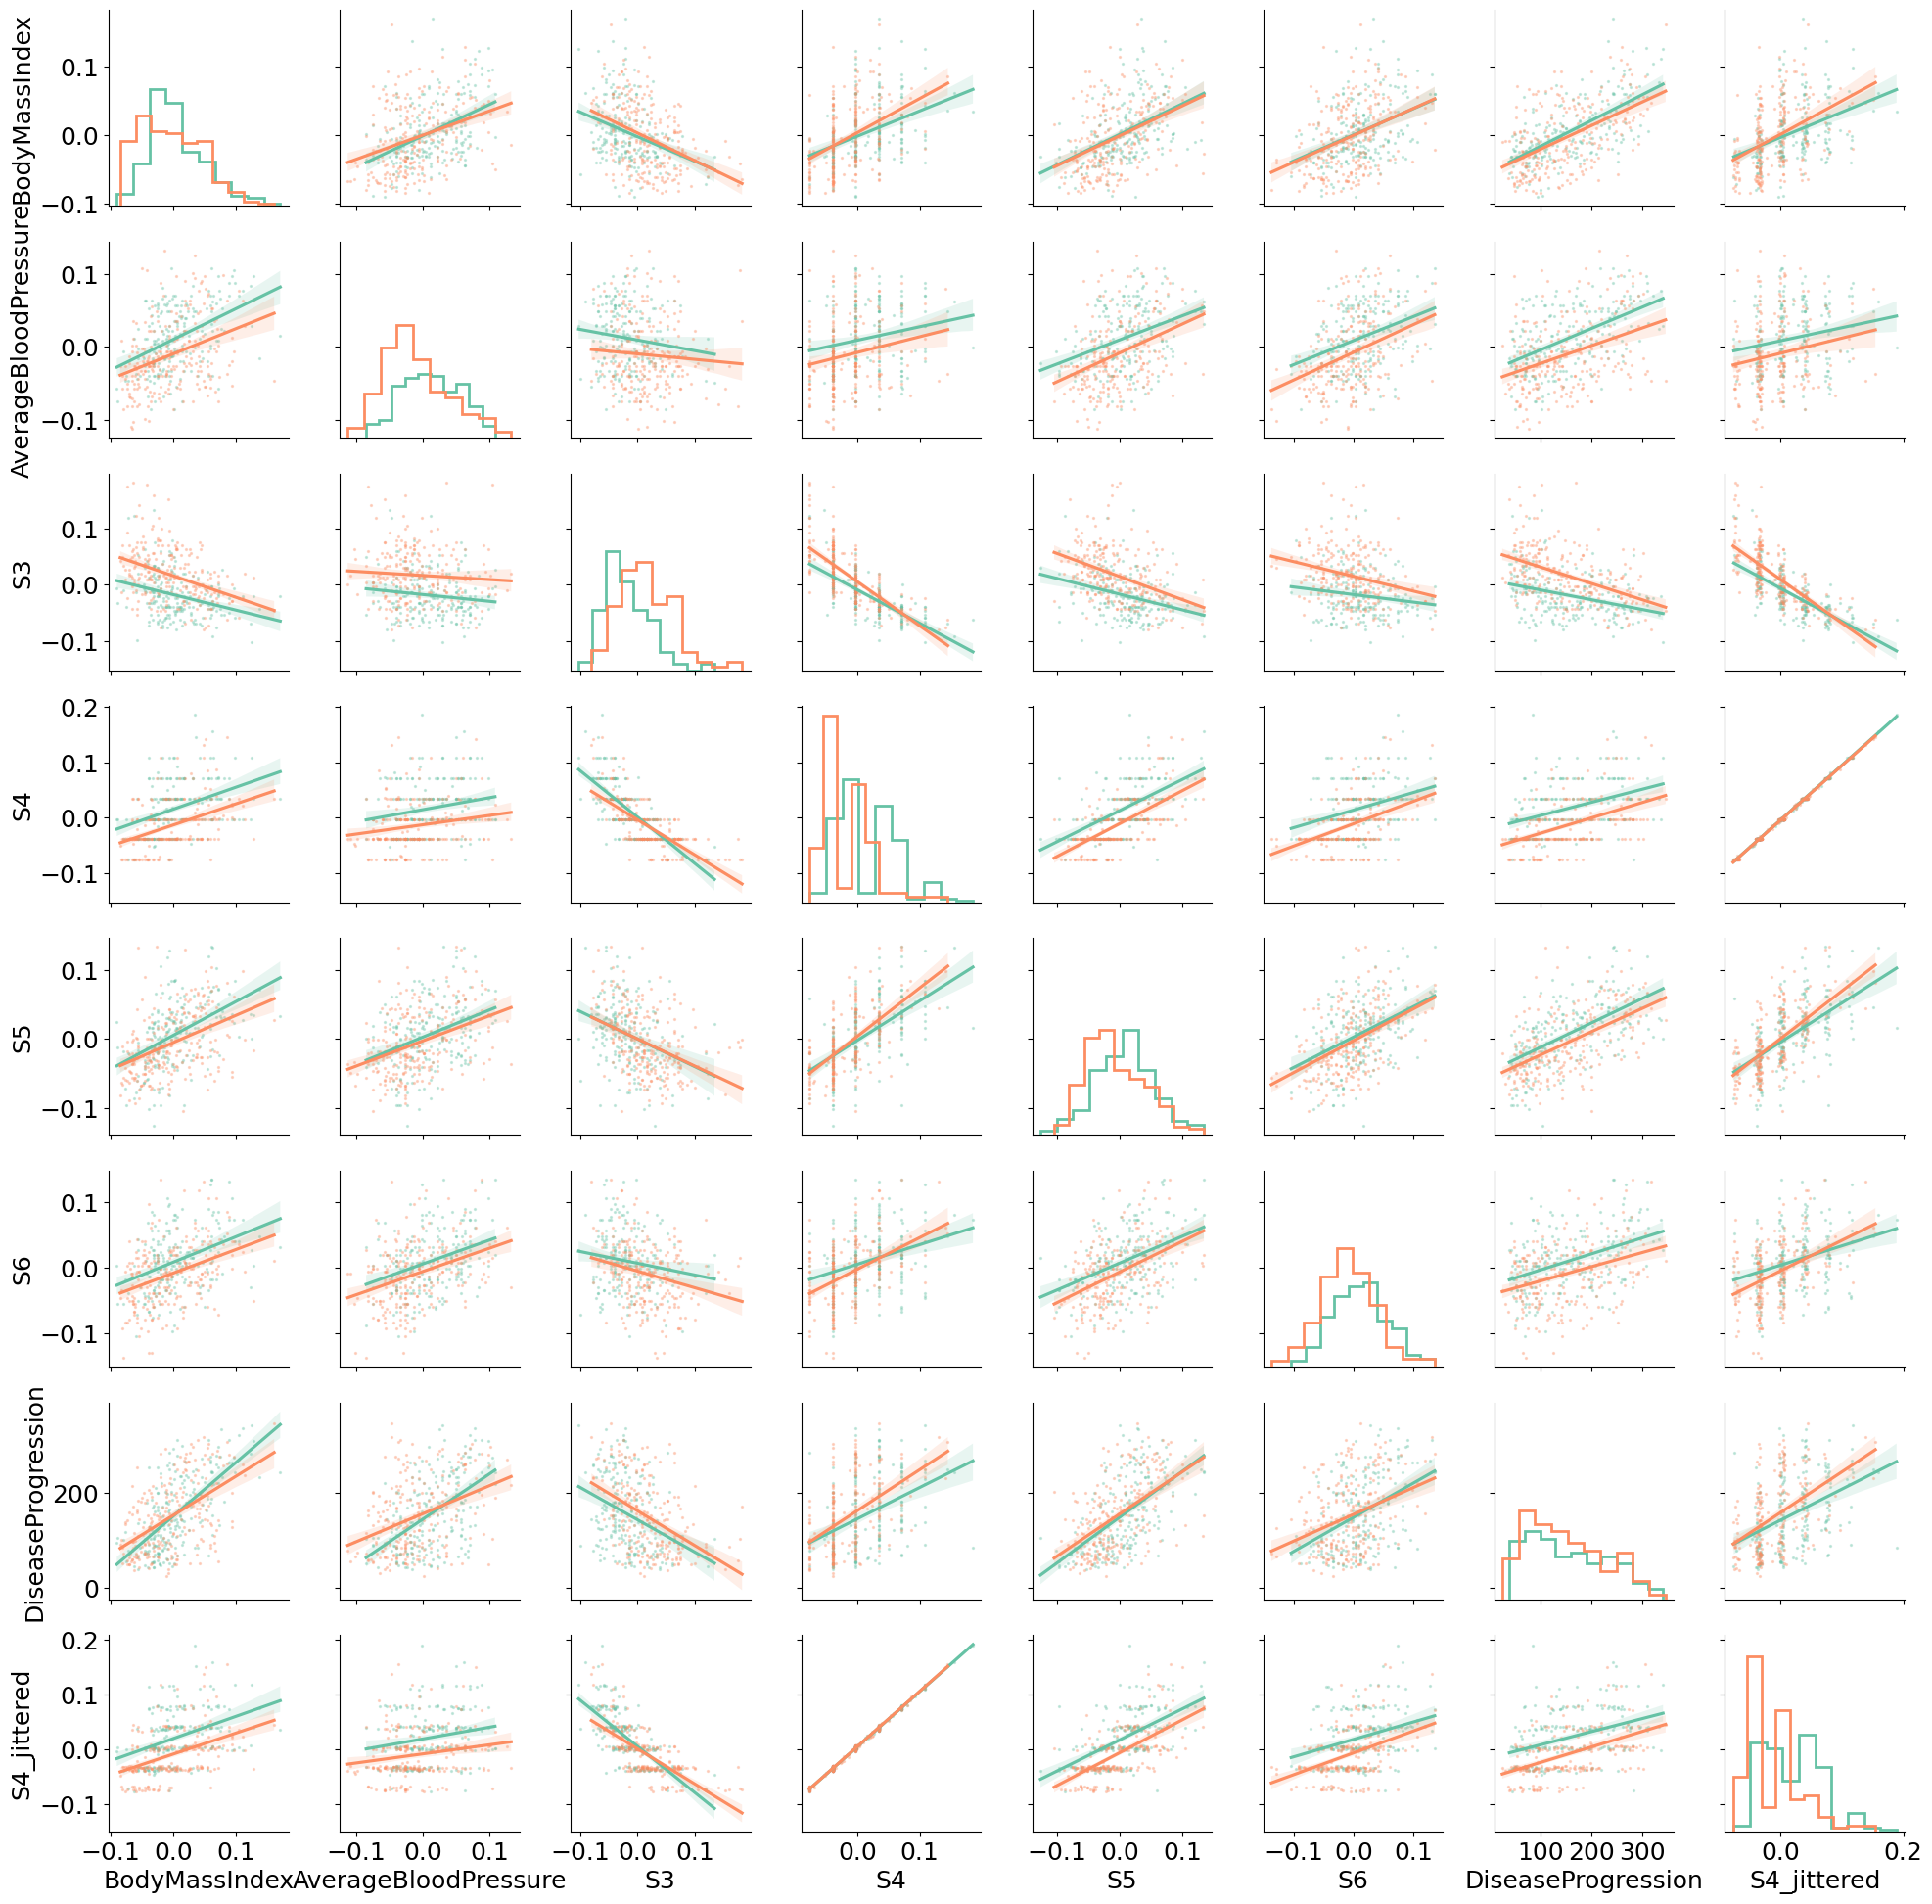

In [32]:
## Remove 'Age', 'S1', and 'S2' from the data
diabetes_subset = diabetes.drop(['Age', 'S1', 'S2'], axis=1)

## Create the scatter plot matrix without 'Age', 'S1', and 'S2'
g = sns.PairGrid(diabetes_subset.drop('Sex', axis=1), hue='sex_categorical', palette="Set2")

## Map the regplot function to both upper and lower parts of the matrix
## Add alpha=0.3 for transparency in the scatter plots
g.map_upper(sns.regplot, order=1, truncate=True, scatter_kws={'alpha': 0.3, 's':2})
g.map_lower(sns.regplot, order=1, truncate=True, scatter_kws={'alpha': 0.3, 's':2})

## Retain the histogram plots on the diagonal
g.map_diag(plt.hist, histtype="step", linewidth=2)

## Display the plot
plt.show()

> Briefly describe at least three of the additional details can you see in this plot.

> **Answers:**

> - Removing the 'Age', 'S1', and 'S2' variables eliminates unnecessary noise from the matrix. As a result, the plot provides a clearer picture of the relationships between the remaining variables and DiseaseProgression. For example, you can now more easily see how variables like BodyMassIndex and BloodPressure correlate with DiseaseProgression

> - The use of transparency (alpha=0.3) in the scatter plots makes it easier to detect areas where data points overlap, which would have been harder to spot with solid markers. This helps you visualize high-density regions better, especially for variables that cluster closely together, like S3 and S4

> - The histograms on the diagonal show the distribution of each variable. By looking at these histograms, you can easily spot skewness or the spread of values for each variable. For example, some variables show a more normal distribution, while others (like S5 and S6) display skewed patterns that could be relevant for further analysis



### Jitter

The scatter plot of the discrete values of the 'S4' variable creates over-plotting. This over-plotting makes interpretation difficult.

Over-plotting in scatter plots is common when one of the variables has discrete values. Adding **jitter** to those discrete values spreads the data points on the plot, limiting the over-plotting.  

Some Seaborn plot types support built-in jitter options. But, this support is limited to categorical variables. However, a jittered variable can easily be created as shown in the code below.  

In [31]:
diabetes.loc[:,'S4_jittered'] = diabetes.loc[:,'S4'].add(nr.uniform(high=0.01, size=diabetes.shape[0]))

A word of caution is required. Too much jitter can distort perception of the relationship shown in the plot. Whereas, too little jitter will not be effective. Some experimentation is typically required to find the amount of jitter that produces a satisfactory display.

> **Exercise 6-6:** Recreate the scatter plot matrix from the previous exercise, 6-5, but use the jittered `S4` variable.

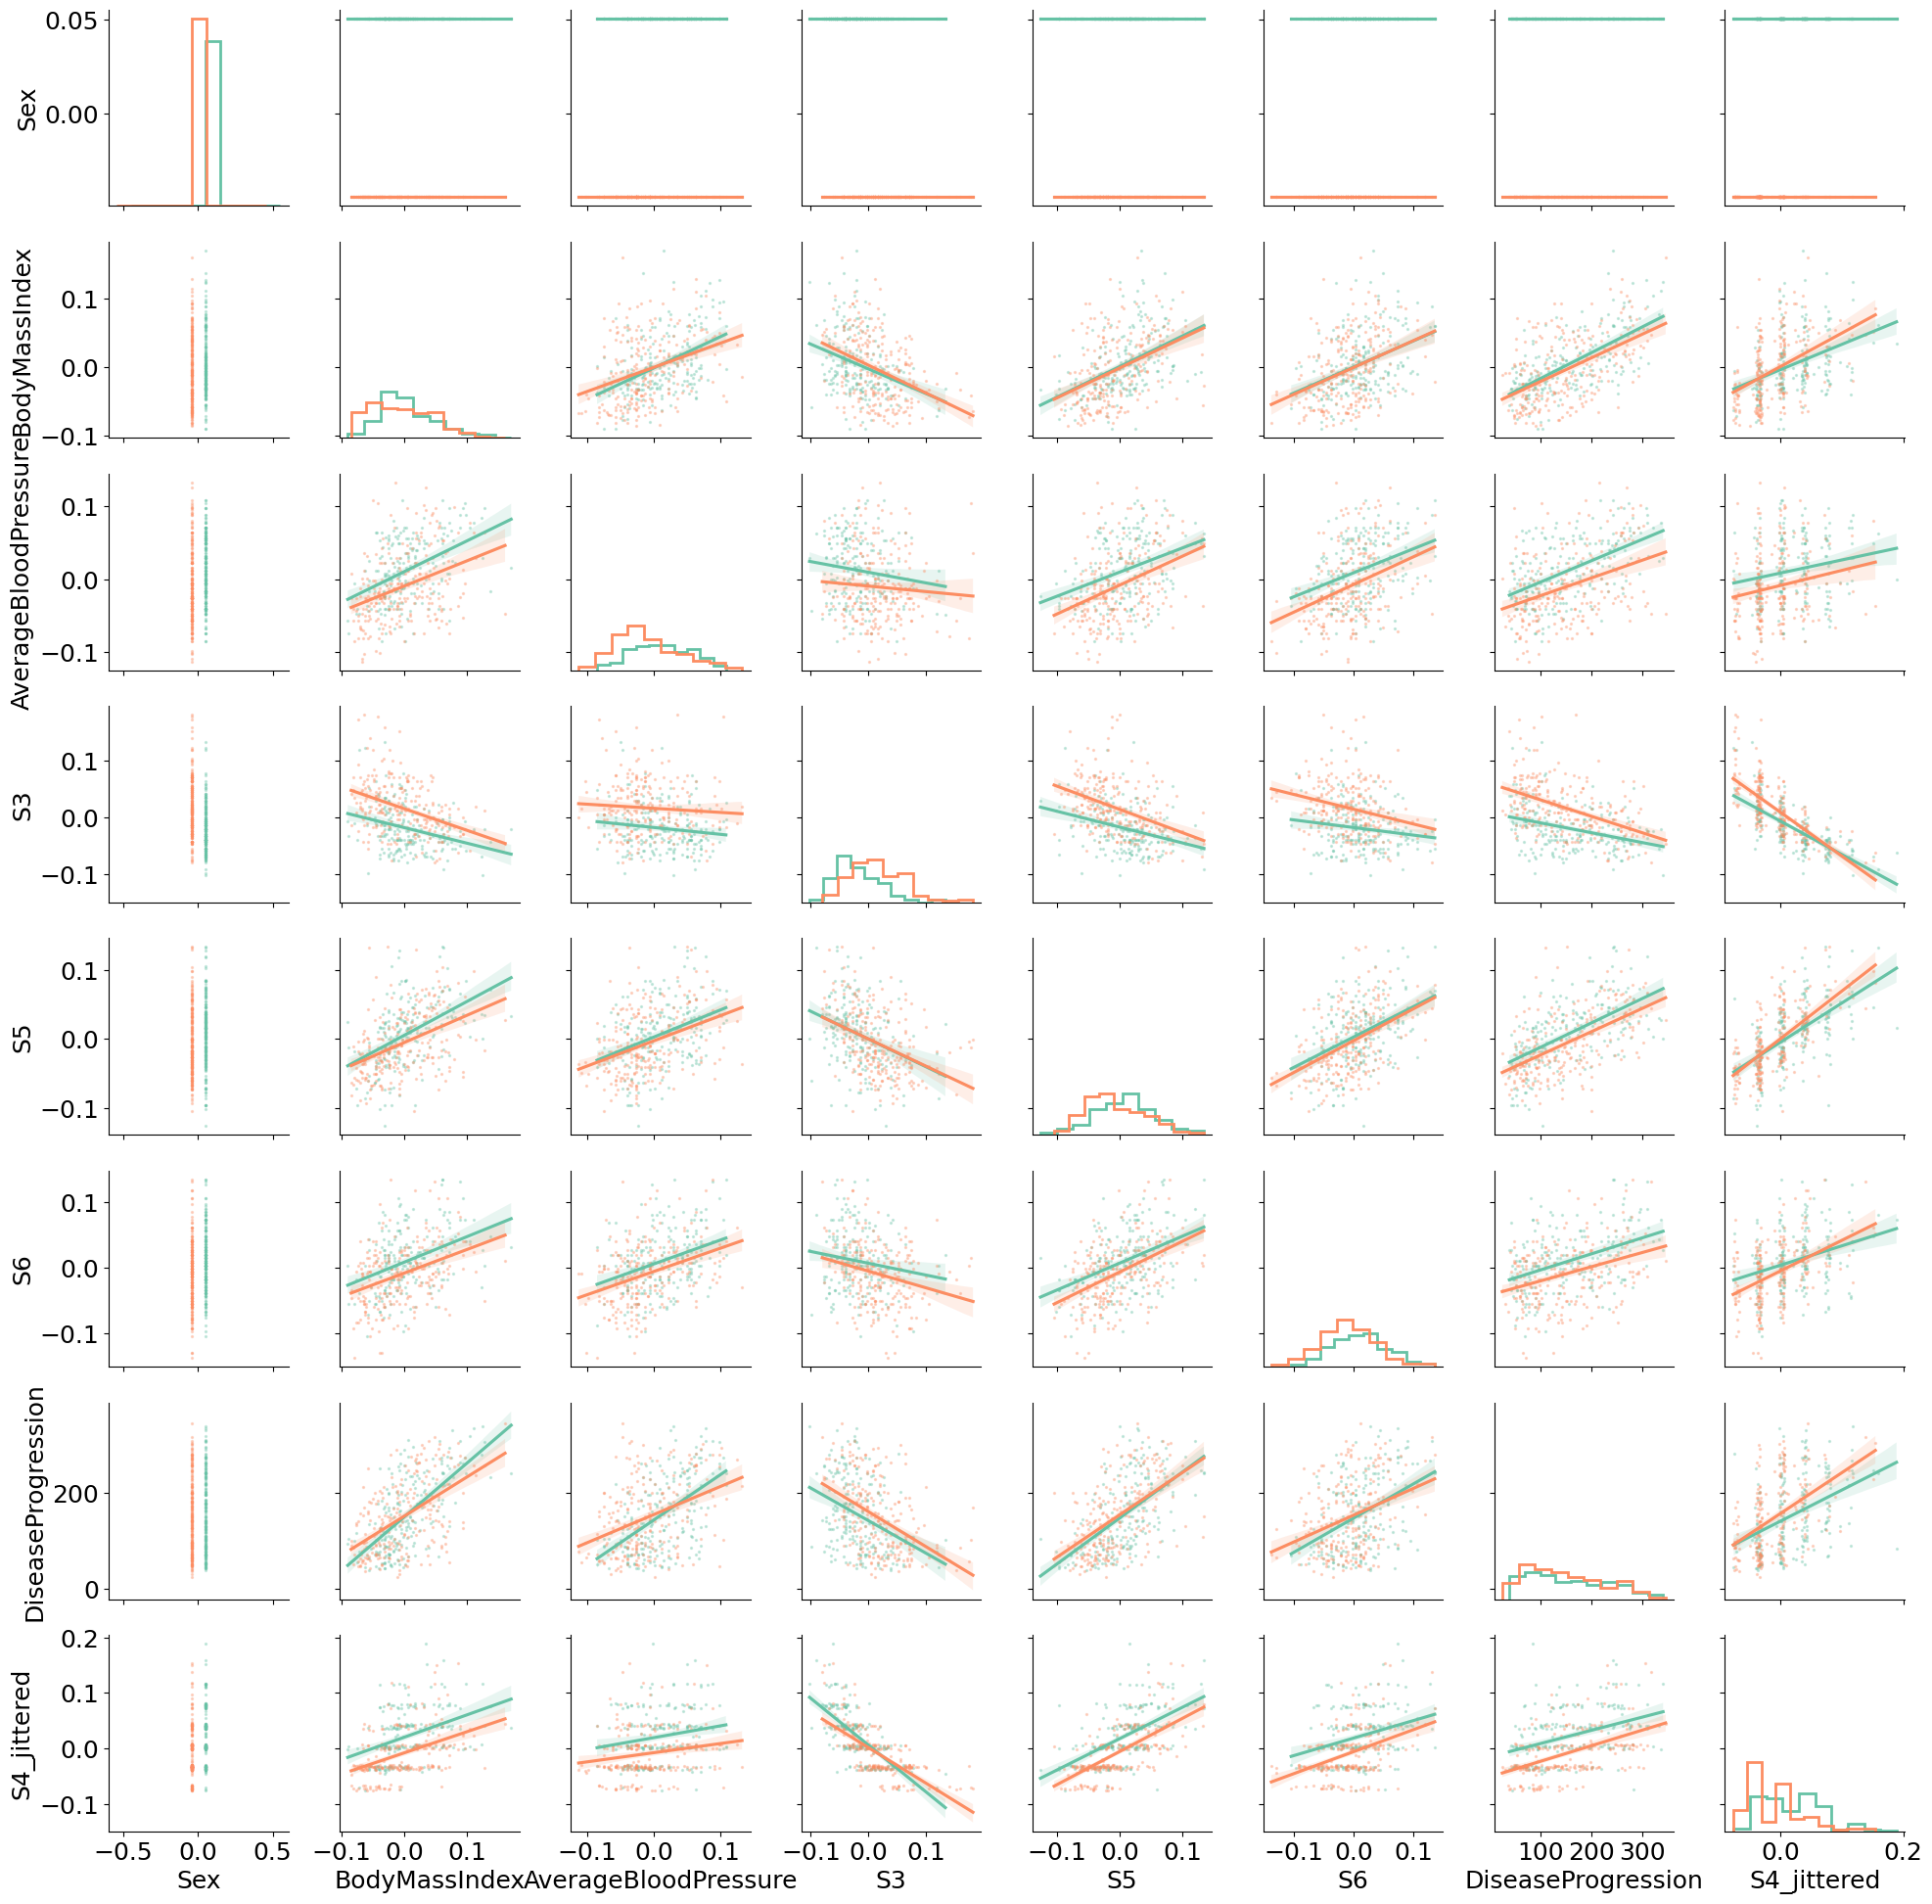

In [33]:
g = sns.PairGrid(diabetes.drop(['Age', 'S1', 'S2', 'S4'], axis=1), hue='sex_categorical', palette="Set2")

# Mapping regplot for both upper and lower plots with scatter_kws to adjust transparency.
g.map_upper(sns.regplot, scatter_kws={'s': 2, 'alpha': 0.3})
g.map_lower(sns.regplot, scatter_kws={'s': 2, 'alpha': 0.3})

# Mapping the diagonal with histograms.
g.map_diag(plt.hist, histtype="step", linewidth=2)

# Show the plot
plt.show()



> Now, answer the following questions:
> 1. How does using a bit of jitter change your perception of the relationships between `S4` and the other variables?
> 2. More specifically, can you tell differences between the two sexes of the patients and is this difference significant to the relationship with other variables?

> **Answers:**

> 1. Adding jitter to the S4 variable helps to spread out the points that were previously overlapping, particularly because S4 has discrete values. This makes it easier to perceive patterns and the strength of relationships between S4 and other variables. The jittered points give us a clearer view of the distribution and relationships, especially where the data was previously over-plotted, making the correlation trends more visually distinct

> 2. Yes, we can see some differences between male and female patients across several variables. In the scatter plots, the regression lines for male and female patients often have different slopes, indicating differences in relationships with certain variables, like Disease Progression and BodyMassIndex. However, while there are visual differences in the trends, it's important to quantify whether these differences are statistically significant through formal tests rather than relying solely on visual perception


## Facet plots

The concept of **facet plots** was independently developed by several researchers in a similar time period. @Cleveland_1993 introduced the concept which he termed **trellis plots** or **conditioned plots**. The same idea was introduced by @Tufte, who called it the **method of small multiples**.   

Regardless of the name applied, the basic idea is straight forward. A series of plots are displayed, each plot conditioned on one or more variables. Conditioning can be viewed as performing a **group by** operation. The conditioning is followed by plotting each of the groups. The plots are displayed on a grid, organized by the vales of the conditioning variables. Ordinarily, the axis scales of each of the plots in the grid is held constant. Using the the same scale makes comparisons between data groups easier.    


### A first facet plot example

Of the many questions we can ask about these data, one is the distribution of the wind speed by month. Wind speed could well influence a persons decision to ride a bike or not.

To investigate this relationship we create a facet plot conditioned on a single variable, month. The code below uses the following steps to create the display:   
1. A [Seaborn FacetGrid object](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) is created. The FacetGrid contains a reference to the data frame, the conditioning column and the order we wish the conditioning column values to be displayed. The later is important since month names are ordered, and having the display following this order aids interpretation of the chart.    
2. The [FacetGrid map method](https://seaborn.pydata.org/generated/seaborn.FacetGrid.map.html) is used to map a specific plot to each group of the data. Many python plotting functions can be used, including a user-defined function. The arguments to the plot function follow to function name.   

In [ ]:
g = sns.FacetGrid(bike_share_df, col='month', col_order=calendar.month_abbr[1:], col_wrap = 4, height=5)
g = g.map(plt.hist, "windspeed", bins=20, color="b", alpha=0.5)
plt.show()

You can see a noticeable change in the distribution of wind speed by month. In particular, higher wind speeds are more likely in the winter and spring months. There are quite a few hours over two years with essentially no wind.

The foregoing example used a single conditioning variable. Facet plots can be laid out on a two dimensional grid using two faceting variables. It is also possible to use the project of multiple variables on a grid axis. This idea is pursued in the exercises.    

These concepts are best illustrated with another example. It will be useful to understand how weather and month of the year affects ridership by hour of the day. The code in the cell below creates a facet plot display using these conditioning variables by the following steps:    
1. The FacetGrid object is created with the weather on the columns and month on the rows of the grid. As before, the values are ordered to aid in interpretation.    
2. The map method is used to display scatter plots of bike demand vs. hour for each group in the facet grid.    


In [ ]:
g = sns.FacetGrid(bike_share_df, col="Weather", col_order=weather.values(), row="month", row_order=calendar.month_abbr[1:], height=2, aspect=2)
g = g.map(sns.scatterplot, "hr", "cnt", s=3, alpha=0.2)
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=10)
plt.show()

There are a number of points one can notice in this display:  
1. There are very few bike rentals when the weather is bad with heavy precipitation.    
2. There is a distinct pattern of bicycle use by time of day, with some peaks around commuter hours.     

There are still a great many relationships one can explore in this moderately complex data set. The exercises suggest some directions you can take to continue this investigation.    

> **Exercise 6-7:** There are two classes of users, casual and registered. Presumably, registered users are more regular in their activity, representing people such as commuters. A reasonable question to ask is how the hourly use pattern of these classes of users differ by month and weather. To explore this question you can make facet plots using color to display the class of user. To do so, make two sets of plots on the same grid object:
> 1. Create a grid object as done in the foregoing example.
> 2. Make two sets of scatter plots on this grid object, using the `registered` and `casual` columns of the data frame. Use a unique value of the `color` argument for each variable. Use alpha $= 0.2$ and s $= 3$ as additional arguments for the scatterplot.     
> 3. The titles of these plots are long. The title font size can be set by looping over the grid as is shown in the foregoing example.
> 4. One pitfall is creating this plot with the correct vertical axis labels. You do not want the name of either class of users to be displayed. To display a meaningful label you must assign a label specifically to each plot on the left side grid using an axes label with the `gridObject.axes[i,j].set_ylabel` method in a loop over the number of months.
> Execute your code.

In [ ]:
## Put your code below






> What differences can you see between the use patterns of the two classes of users?

> **Answer:**    

> **Exercise 6-8:** As was discussed, most any plot type, including user defined plot functions can be used in a facet plot array. Previously, a scatter plot of bike users vs. hour of the day by weather condition was created. As an alternative to the plot you created in the foregoing example, make a facet plot using a time ordered set of box plots, binned by hour, wiyh the same facet grid layout. Create this plot only for the total counts. Note, you can suppress the warning by specifying `order=None`.  

In [ ]:
## Put your code below


> State at least two differences you can see when compared to the conditioned scatter plots?

> **Answer:** There are at least two aspects of the data that are more clearly noticable when compared to the scatter plot.    
> 1.     
> 2.    

> **Exercise 6-9:** You have seen that fewer people use bicycles as precipitation increases. But, what is the effect of temperature and wind speed. How can you make a facet plot with these numeric variables? One possible approach is to put these values into 3 equal width non-overlapping bins to create categorical variables. The result will be a 3x3 facet grid of levels (categories) of temperature and wind speed. Be sure to give each category a meaningful name. Specifically, do the following:      
> 1. Create variables with 3 equal width bins for both temperature and wind speed. The bins should span the maximum to the minimum values of each variable. The [numpy.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function will help you perform this operation.  
> 2. Use the [pandas.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) method to create binned categorical variables named low, medium nd high.  
> 3. Create a facet grid with binned temperature in the columns and binned wind speed in the rows.     
> 4. Map scatter plots of count of users onto the facet grid.
> Execute your code.  

In [ ]:
## Put your code below




> What does this plot tell you about changes in bicycle use with temperature and wind speed?  

> **Answer:**         

## Cognostics

With complex data there are so many possible relationships that one will
never have the time and patience to look at all of them. The question is, how can you sort through the many possibilities to find the ones of greatest interest?

There are a number of ways to sort relationships in complex data so that you can find the most interesting ones. The basic idea is to use some type of summary statistic to order these relationships. @Tukey_1982 and @Tukey_1985 called these statistics **cognostics**. This idea was extended by @Wilkinson_2008 to include a number of scatter plot specific statistics. They use another Tukey term **Scagnostics** for this collection of methods   

The general cognostics algorithm has only a few main steps:    
1. Data are grouped using the specified variables.   
2. The cognostic is computed for each group.    
3. Sort the cognostic values.
4. Display the relationships which the congnosic indicates are of the greatest interest.  

### Find States With Largest Price Increases

The housing data is organized by state and county. A reasonable question to ask is how to display the data for the 8 states which had the greatest increase in median price? Looking at plots of all 50 state is not a productive approach.  

Finding and plotting the data of greatest interest is simple, given the right cognostic. We will use an **ordinary least squares (OLS)** regression model. Details of OLS regression are discussed in part 4 of this book. For now, our regression model will have a single **slope coefficient** which parameterizes the rate of change of the median home price. This slope coefficient is the cognostic we will use to sort the many possible charts of median price vs. time.     

There are a number of steps required to compute the cognostic. The code below prepares the data frame:  
1. Creates an intercept column in the data frame. The intercept column is just a column of all 1s. This intercept is used to compute the linear regression models.     
2. Create a column with zero-mean (de-meaned) decimal time. Time is our only independent or predictor variable for this simple model. We want a slope coefficient that represents relative rate of change. To achieve this goal the predictor variable must have a mean value of 0.     

In [ ]:
## Add an intercept column to the data frame
housing.loc[:,'intercept'] = [1.0] * housing.shape[0]
## Demean the decimal time column
mean_time = housing.loc[:,'time_decimal'].mean()
housing.loc[:,'time_demean'] = housing.loc[:,'time_decimal'].subtract(mean_time)


We are now ready to compute the cognostic, or slope coefficient. The code in the cell below does this by these steps:   
1. The `prepare_temp` function creates a data frame with a subset of the overall data frame. The price variable is then standardized by subtracting the mean and dividing by the standard deviation. This standardization is required so that we are comparing the relative rates of change of median prices. Otherwise, the slope coefficients of the groups will be scale-dependent and therefore biased.    
2. The slope coefficient of each group is computed using the [statsmodels.regression.linear_model.OLS](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html) function from the Statsmodels package. The results for each group are appended to lists.
3. The lists are formed into a data frame, sorted by value of the slope coefficient, and returned by the function.

> **Computational note:** In the code shown here the cognostic, slope coefficient, is computed sequentially in a for loop. However, the computation of each of these cognostic values is independent of the others. This means that these calculations can be fully parallelized.  


In [ ]:
## Find the slope coefficients for each state
def prepare_temp(df, group_value, group_variable = 'state'):
    temp = df.loc[df.loc[:,group_variable]==group_value,:].copy()
    mean_price = np.mean(temp.loc[:,'log_medSoldPriceSqft'])
    temp.loc[:,'log_medSoldPriceSqft'] = np.subtract(temp.loc[:,'log_medSoldPriceSqft'], mean_price)
    std_price = np.std(temp.loc[:,'log_medSoldPriceSqft'])
    temp.loc[:,'log_medSoldPriceSqft'] = np.divide(temp.loc[:,'log_medSoldPriceSqft'], std_price)
    return(temp, mean_price, std_price)


def compute_slopes(df, column, group_variable='state', ascending=False):
    slopes = []
    entities = []
    intercepts = []
    for e in df.loc[:,column].unique():
        temp, mean_price, std_price = prepare_temp(df, e, group_variable=column)
        temp_OLS = sm.OLS(temp.loc[:,'log_medSoldPriceSqft'],temp.loc[:,['intercept','time_demean']]).fit()
        slopes.append(temp_OLS.params.time_demean)
        intercepts.append(temp_OLS.params.intercept)
        entities.append(e)

    slopes_df = pd.DataFrame({'slopes':slopes, 'intercept_coef':intercepts, 'entity_name':entities})
    slopes_df.sort_values(by='slopes', ascending=ascending, inplace=True)
    slopes_df.reset_index(inplace=True, drop=True)
    return slopes_df

state_slopes = compute_slopes(housing, 'state')
state_slopes[:10]


The first few slopes show the expected descending order. These results can now be queried to find interesting relationships. We will start by asking which states had the fastest rate of property prices increase in the time period.

The function in the code below subsets the data frame containing the cognostic. The subsets are for the range of cognostic values specified. The full data fame is then subsetted using the key column specified. The cognostic data frame and the subset are then joined using the Pandas [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function, and the result is returned.  


In [ ]:
## PLot states with the fastest growing pricing
def find_changes(df, slopes, start, end, col='state'):
    increase  = slopes.loc[start:end,'entity_name']
    increase_df = df.loc[df.loc[:,col].isin(increase),:]
    increase_df = increase_df.merge(slopes, how='left', right_on='entity_name', left_on=col)
    return(increase_df, increase)
big_increase_states, increase_states = find_changes(housing, state_slopes, 0, 7)


In [ ]:
big_increase_states

Next, scatter plots of the query results are displayed. The function in the code block below creates these scatter plots. The function places scatter plots of each subset of the data on a facet grid. A regression line is displayed on each scatter plot using the Seaborn `regplot` function. Alternatively, the results of the regression used to compute the cognostic can be used. However, the later approach requires more code.   



In [ ]:
## Display scatterplot vs time
def plot_price_by_entity(df, order, entity='state', xlims=[2007.5, 2016.5], alpha=0.1):
    g = sns.FacetGrid(df, col=entity, col_wrap=4, height=6, col_order=order)
    g = g.map(sns.regplot, 'time_decimal', 'log_medSoldPriceSqft',
              line_kws={'color':'red'}, scatter_kws={'alpha': alpha})
    g.set(xlim=(xlims[0],xlims[1]))
    plt.show()

plot_price_by_entity(big_increase_states, increase_states)


We can see that median house prices for the states shown all had increases for the 8 year period displayed.

Another interesting question is which states had the largest decrease in median house prices. The code below queries the data and displays the result.


In [ ]:
## PLot states with the fastest decrease in prices
big_decrease_states, decrease_states = find_changes(housing, state_slopes, 41, 49)
plot_price_by_entity(big_decrease_states, decrease_states)


> **Exercise 6-10:** New Jersey is one of the states with the largest rate of decrease in price (largest magnitude of negative slope). You can use cognostics to find more details of relationships in a data set. In this case, find the 8 New Jersey counties with the fastest rates of price decline and display the time series plots. Note, you can use the functions provided to find the counties of interest and plot the results.   

In [ ]:
## Put your code below




> Provide short answers to the following questions:     
> 1. What primary observation can you make from these charts?         
> 2. Are the price changes constant or do they exhibit some periodic or seasonal behavior?        

> **Answers:**     
> 1.     
> 2.     

> **Exercise 6-11:** Another interesting query is to find the counties with the greatest median prices, for the state of California. With 57 counties, finding the answer to this question manually is a lot of work. To answer this question, compute a cognostic of the median sale price by county. Then display the scatter plot of the 8 counties with the greatest median. Some tips that will help you with this problem:      
> 1. Create a data frame with just the counties of California.
> 2. The median of the `log_medSoldPriceSqft` for each county can be computed using the [pandas.DataFrame.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function, followed by the [pandas.DataFrame.median](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html) function.   
> 3. Print the meadian prices of the 8 counties with the highest median prices.     
> 4. Display a facet plot of log median price per square root by time for the 8 counties with highest median price. Use the index of the median price data frame (county name) for the `order` argument of the `plot_price_by_entity` function.  

In [ ]:
## Put your code below




> Provide short answers to the following questions:     
> 1. Does there appear to be any relationship between the average rate of change (slope of regression line) and the median price of housing over time and why?     
> 2. Which county has the greatest uncertainty in the average rate of change of median sale price and why?

> **Answers:**        
> 1.     
> 2.     

#### Copyright 2020, 2021, 2022, 2023, 2024 Stephen F. Elston. All rights reserved.       

## Bibliography